# Imports, settings & globals

In [1]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021"
sys.path.append("../bda_models")
sys.path.append(CODE_DIR)

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from tabulate import tabulate

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()
import torch.distributions as td

from datasets import load_dataset, ReadInstruction

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *
from analysis.bda_models.bda_topic_model_ptb import GenLDATopicModelPTB
from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

from gensim_LDA import LdaModel # I made local alterations
from gensim.models import CoherenceModel # from the gensim module

In [3]:
SAVE_DIR = "output_files"

SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/topic_model_surprisal_values.pt"

SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/topic_model_surprisal_dp_mixtures.p"

SAVE_TUNING_RESULT_FILE = f"{SAVE_DIR}/topic_model_tuning_results.pt"

SAVE_DP_COMP_KL_DISTS_FILE = f"{SAVE_DIR}/topic_model_dp_mixtures_kl_comp_dists.pt"

os.makedirs(SAVE_DIR, exist_ok=True)

In [6]:
PERFORM_HP_TUNING = False

FIT_AND_COMPUTE_SURPRISAL_VALS = True

PERFORM_MODEL_CHECKS = False

FIT_SURPRISAL_DPS = False

# Load overview of relevant PTB runs

In [5]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
overview_df = overview_df[overview_df.image_or_language == "language"]

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

overview_df.head()

,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,100,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=1...."
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10..."


# Get PTB data (train & valid)

In [7]:
if PERFORM_HP_TUNING or FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:
    # PENN TREE BANK
    ptb_train_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="train")
    ptb_train_text_samples = ptb_train_dataset["sentence"]

    ptb_valid_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="validation")
    ptb_valid_text_samples = ptb_valid_dataset["sentence"]

    print(f"Len train samples", len(ptb_train_text_samples))
    print(f"Len valid samples", len(ptb_valid_text_samples))

W0123 14:25:20.010408 23147488268032 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)
W0123 14:25:20.569735 23147488268032 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)


Len train samples 42068
Len valid samples 3370


# LDA hyper parameter tuning

In [8]:
model_results = None

if not PERFORM_HP_TUNING:
    if not os.path.exists(SAVE_TUNING_RESULT_FILE):
        print("No saved tuning results to load. Set SAVE_TUNING_RESULT_FILE=True to run.")
    else:
        model_results = torch.load(SAVE_TUNING_RESULT_FILE)
else:
    # Topics range
    min_topics = 4
    max_topics = 12
    step_size = 2
    topics_range = range(min_topics, max_topics, step_size)

    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3)) + ["auto", "asymmetric"]

    # Beta parameter
    # beta = list(np.arange(0.01, 1, 0.3))
    # beta.append('symmetric')
    beta = ["auto"]

    # Can take a long time to run
    counter = 1
    total_exp = int(len(alpha) * len(beta) * len(topics_range))
    
    temp = GenLDATopicModelPTB(train_samples_strings=ptb_train_text_samples, preprocess_only=True)
    train_id2word = temp.dictionary
    train_docs = temp.train_docs
    train_corpus = temp.train_corpus
    valid_corpus, valid_docs = temp.lda_preprocess_transform(text_samples=ptb_valid_text_samples)

    for k in topics_range:
        for a in alpha:
            for b in beta:

                print("-"*80)
                print(f"Experiment {counter}/{total_exp}")
                print(f"K={k} alpha={a} beta={b}")

                coherence_score, log_ppl = evaluate_setting(train_corpus=train_corpus, 
                                 train_docs=train_docs, 
                                 train_id2word=train_id2word, 
                                 valid_corpus=valid_corpus, 
                                 k=k, 
                                 a=a, 
                                 b=b)

                print(f"Coherence score: {coherence_score:.2f}")
                print(f"Log perplexity: {log_ppl:.2f}")

                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence (CV)'].append(coherence_score)
                model_results['Log PPL'].append(log_ppl)

            torch.save(model_results, SAVE_TUNING_RESULT_FILE)
            counter += 1

I0123 14:25:47.725749 23147488268032 utils.py:145] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0123 14:25:47.727404 23147488268032 utils.py:157] NumExpr defaulting to 8 threads.


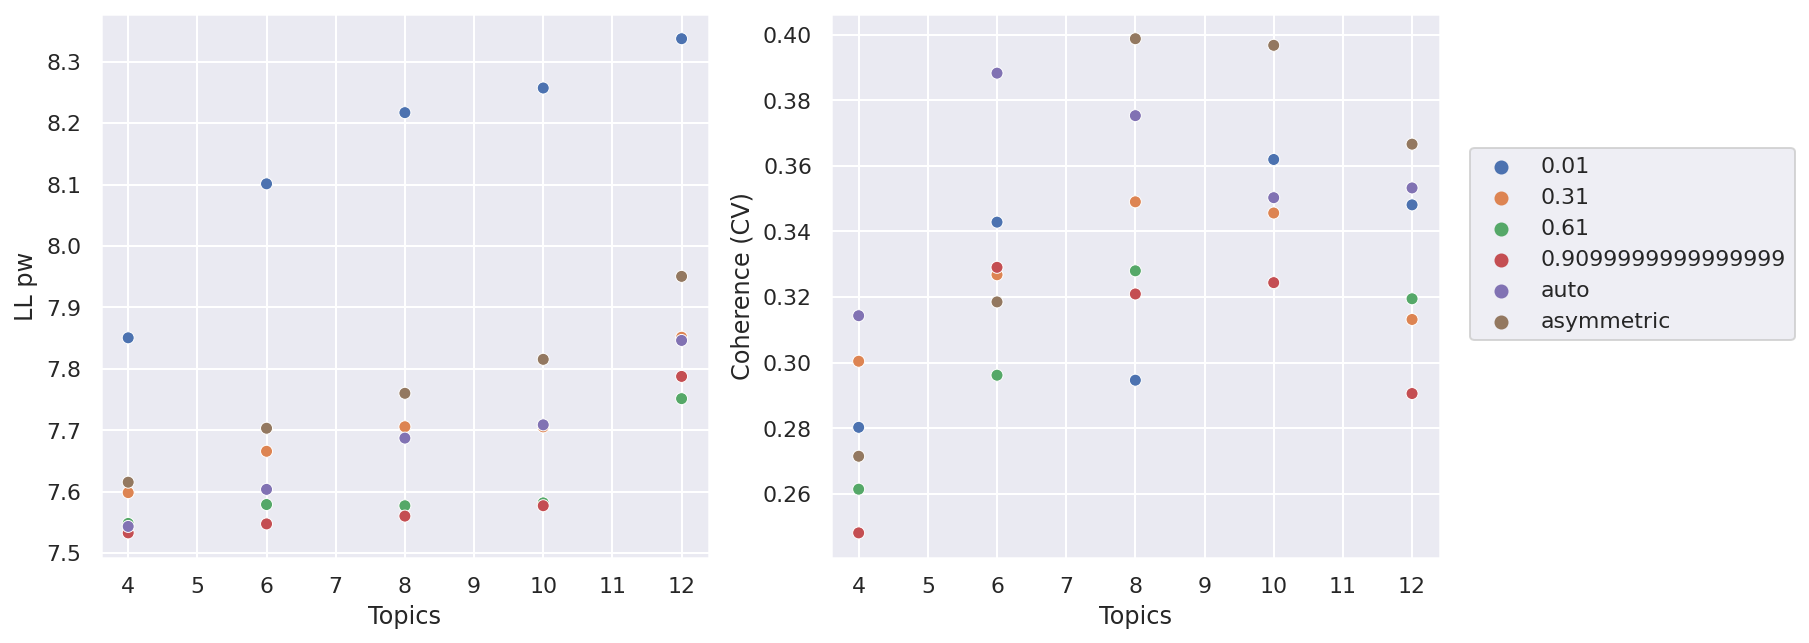

In [9]:
if model_results is not None:
    df = pd.DataFrame(model_results)

    df["LL pw"] = - df["Log PPL"]

    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    sns.scatterplot(data=df, x="Topics", y="LL pw", hue="Alpha", ax=axs[0])
    sns.scatterplot(data=df, x="Topics", y="Coherence (CV)", hue="Alpha", ax=axs[1])

    axs[0].legend().remove()
    axs[1].legend(loc=(1.05, 0.4))

In [10]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:
    # Read of grid search
    ALPHA = 0.01
    BETA = "auto"
    N_TOPICS = 10

    gen_model_lda = GenLDATopicModelPTB(
        train_samples_strings=ptb_train_text_samples, 
        alpha=ALPHA,
        beta=BETA,
        num_topics=N_TOPICS, 
        chunksize=2000, 
        passes=20, 
        iterations=600, 
        eval_every=None)

I0123 14:25:54.133674 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:25:54.135759 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:25:54.245512 23147488268032 phrases.py:588] PROGRESS: at sentence #10000, processed 121114 words and 82407 word types
I0123 14:25:54.359352 23147488268032 phrases.py:588] PROGRESS: at sentence #20000, processed 242178 words and 144895 word types
I0123 14:25:54.474598 23147488268032 phrases.py:588] PROGRESS: at sentence #30000, processed 360298 words and 198359 word types
I0123 14:25:54.586887 23147488268032 phrases.py:588] PROGRESS: at sentence #40000, processed 479256 words and 249273 word types
I0123 14:25:54.611516 23147488268032 phrases.py:609] collected 259273 token types (unigram + bigrams) from a corpus of 503752 words and 42068 sentences
I0123 14:25:54.613064 23147488268032 phrases.py:666] merged Phrases<259273 vocab, min_count=20, threshold=10.0, max_vocab_size=40000

Number of unique tokens: 8478
Number of documents: 42068


I0123 14:28:10.582429 23147488268032 utils.py:447] LdaModel lifecycle event {'msg': 'trained LdaModel<num_terms=8478, num_topics=10, decay=0.5, chunksize=2000> in 130.54s', 'datetime': '2022-01-23T14:28:10.579164', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


In [11]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:
    if PERFORM_MODEL_CHECKS:
        # Word frequency distribution
        n_samples = 50
        topic_model = gen_model_lda.lda_model
        valid_corpus, _ = gen_model_lda.lda_preprocess_transform(text_samples=ptb_valid_text_samples)
        word_dists_orig, word_dists_resample = resample_corpus(valid_corpus, topic_model, 
                                                               n_samples=n_samples, max_docs=None)

        plot_word_dists(word_dists_orig, word_dists_resample)

        word_dists_orig.shape, word_dists_resample.shape
    
        # P value hist
        pvals = (word_dists_resample > word_dists_orig[:, None, :]).mean(axis=1)
        pvals = pvals.flatten()

        plt.hist(pvals, bins=50, density=True)
        plt.axvline(pvals.mean(), linestyle="--", color="black")
        _ = plt.xlabel(f'Pr(sampled freqs. > obs freqs.)')
        _ = plt.ylabel("Frequency")
        plt.show()

        # Print topics
        topics = gen_model_lda.lda_model.show_topics()

        table = []
        headers = ["Topic"] + [f"{i}" for i in range(10)]

        for t_idx in range(N_TOPICS):
            top_terms = gen_model_lda.lda_model.get_topic_terms(t_idx, topn=10)
            out = [train_id2word[idx] for (idx, _) in top_terms]
            out = [t_idx] + out
            table.append(out)

        print(tabulate(table, headers=headers))

# Load samples to evaluate surprisal of

In [12]:
MAX_MODEL_SAMPLES = 200
EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

if FIT_AND_COMPUTE_SURPRISAL_VALS:

    ptb_model_text_samples = dict()

    for i, (clean_name, row) in enumerate(overview_df.iterrows()):
        print(i, clean_name)

        save_dir = f"{EXPORT_DIR}/{row.run_name}"
        conditional_samples_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
        samples_file = f"{save_dir}/{SAMPLE_FILE}"

        cond_samples = torch.load(conditional_samples_file)["valid"]
        samples = torch.load(samples_file)

        d = {
            "conditional_original_text": cond_samples["original_input_text"][:MAX_MODEL_SAMPLES],
            "conditional_sampled_text": cond_samples["condtional_sample_text"][:MAX_MODEL_SAMPLES],
            "unconditional_sampled_text": samples["text"][:MAX_MODEL_SAMPLES]
        }

        ptb_model_text_samples[clean_name] = d

        for k, v in ptb_model_text_samples[clean_name].items():
            print(k, len(v))

        print()

    ptb_model_text_samples["data_group"] = {
        "conditional_original_text": ptb_valid_text_samples,
        "conditional_sampled_text": ptb_valid_text_samples,
        "unconditional_sampled_text": ptb_valid_text_samples
    }

0 INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

1 INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

2 INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

3 INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

4 INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

5 INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

6 INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

7 INFO-VA

# Assess surprisal of model samples under generative model

In [13]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:
    gen_topic_model = gen_model_lda

    N_PERM = 100

    surprisal_values = dict()

    for idx, (clean_name, text_samples) in enumerate(ptb_model_text_samples.items()):
        print(f"{idx:2d}/{len(ptb_model_text_samples.keys())}")

        surprisal_values[clean_name] = gen_topic_model.assess_surprisal_under_model(text_samples, N_perm=N_PERM)

    torch.save(surprisal_values, SAVE_BDA_SURPRISAL_VALS_FILE)
else:
    if not os.path.exists(SAVE_BDA_SURPRISAL_VALS_FILE):
        print("No surprisal values found. You need to set FIT_AND_COMPUTE_SURPRISAL_VALS=True and run NB again.")
    else:
        surprisal_values = torch.load(SAVE_BDA_SURPRISAL_VALS_FILE)

I0123 14:29:00.948669 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:00.951157 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:00.955170 23147488268032 phrases.py:609] collected 3760 token types (unigram + bigrams) from a corpus of 2773 words and 200 sentences
I0123 14:29:00.956735 23147488268032 phrases.py:666] merged Phrases<3760 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:00.958521 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3760 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:00.958495', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:29:00.980020 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:00.981484 

 0/24


I0123 14:29:10.608114 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:10.609585 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:10.613189 23147488268032 phrases.py:609] collected 3710 token types (unigram + bigrams) from a corpus of 2663 words and 200 sentences
I0123 14:29:10.614523 23147488268032 phrases.py:666] merged Phrases<3710 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:10.615878 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3710 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:10.615853', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


 1/24


I0123 14:29:10.635963 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:10.637304 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:10.640815 23147488268032 phrases.py:609] collected 3759 token types (unigram + bigrams) from a corpus of 2698 words and 200 sentences
I0123 14:29:10.642146 23147488268032 phrases.py:666] merged Phrases<3759 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:10.643480 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3759 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:10.643458', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:29:10.661767 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:10.663095 

I0123 14:29:19.248471 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:19.249834 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:19.253315 23147488268032 phrases.py:609] collected 3658 token types (unigram + bigrams) from a corpus of 2625 words and 200 sentences
I0123 14:29:19.254631 23147488268032 phrases.py:666] merged Phrases<3658 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:19.255965 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3658 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:19.255944', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:29:19.274648 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:19.275974 

 2/24


I0123 14:29:28.277567 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:28.278988 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:28.282761 23147488268032 phrases.py:609] collected 3872 token types (unigram + bigrams) from a corpus of 2860 words and 200 sentences
I0123 14:29:28.284090 23147488268032 phrases.py:666] merged Phrases<3872 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:28.285501 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3872 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:28.285476', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:29:28.305702 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:28.307029 

 3/24


I0123 14:29:28.337904 23147488268032 phrases.py:609] collected 3309 token types (unigram + bigrams) from a corpus of 2603 words and 200 sentences
I0123 14:29:28.339227 23147488268032 phrases.py:666] merged Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:28.340555 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:28.340535', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


I0123 14:29:37.224973 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:37.226357 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:37.229769 23147488268032 phrases.py:609] collected 3463 token types (unigram + bigrams) from a corpus of 2496 words and 200 sentences
I0123 14:29:37.231108 23147488268032 phrases.py:666] merged Phrases<3463 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:37.232457 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3463 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:37.232433', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:29:37.250676 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:37.252006 

 4/24


I0123 14:29:45.746127 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:45.747497 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:45.751078 23147488268032 phrases.py:609] collected 3703 token types (unigram + bigrams) from a corpus of 2634 words and 200 sentences
I0123 14:29:45.752384 23147488268032 phrases.py:666] merged Phrases<3703 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:45.753707 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3703 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:45.753685', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:29:45.772529 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:45.773836 

 5/240


I0123 14:29:54.201146 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:54.202533 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:29:54.206025 23147488268032 phrases.py:609] collected 3595 token types (unigram + bigrams) from a corpus of 2628 words and 200 sentences
I0123 14:29:54.207349 23147488268032 phrases.py:666] merged Phrases<3595 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:29:54.208684 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3595 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:29:54.208660', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:29:54.226939 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:29:54.228248 

 6/24


I0123 14:30:02.487197 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:02.488624 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:30:02.492082 23147488268032 phrases.py:609] collected 3427 token types (unigram + bigrams) from a corpus of 2443 words and 200 sentences
I0123 14:30:02.493418 23147488268032 phrases.py:666] merged Phrases<3427 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:30:02.494754 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3427 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:30:02.494732', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:30:02.512668 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:02.513984 

 7/240


I0123 14:30:10.724769 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:10.726160 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:30:10.729537 23147488268032 phrases.py:609] collected 3296 token types (unigram + bigrams) from a corpus of 2379 words and 200 sentences
I0123 14:30:10.730875 23147488268032 phrases.py:666] merged Phrases<3296 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:30:10.732219 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3296 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:30:10.732195', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:30:10.748822 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:10.750148 

 8/24
99/100

I0123 14:30:18.702172 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:18.703538 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:30:18.707030 23147488268032 phrases.py:609] collected 3504 token types (unigram + bigrams) from a corpus of 2494 words and 200 sentences
I0123 14:30:18.708358 23147488268032 phrases.py:666] merged Phrases<3504 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:30:18.709694 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3504 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:30:18.709672', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:30:18.726969 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:18.728294 

 9/24


I0123 14:30:27.274140 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:27.275532 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:30:27.279085 23147488268032 phrases.py:609] collected 3546 token types (unigram + bigrams) from a corpus of 2529 words and 200 sentences
I0123 14:30:27.280395 23147488268032 phrases.py:666] merged Phrases<3546 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:30:27.281727 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3546 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:30:27.281703', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:30:27.299693 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:27.301060 

10/24


I0123 14:30:35.491569 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:35.492997 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:30:35.496341 23147488268032 phrases.py:609] collected 3295 token types (unigram + bigrams) from a corpus of 2363 words and 200 sentences
I0123 14:30:35.497656 23147488268032 phrases.py:666] merged Phrases<3295 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:30:35.498978 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3295 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:30:35.498956', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:30:35.516422 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:35.517812 

11/24


I0123 14:30:43.695171 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:43.696575 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:30:43.700098 23147488268032 phrases.py:609] collected 3585 token types (unigram + bigrams) from a corpus of 2584 words and 200 sentences
I0123 14:30:43.701431 23147488268032 phrases.py:666] merged Phrases<3585 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:30:43.702771 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3585 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:30:43.702748', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:30:43.721102 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:43.722430 

12/24


I0123 14:30:52.280942 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:52.282299 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:30:52.285779 23147488268032 phrases.py:609] collected 3524 token types (unigram + bigrams) from a corpus of 2529 words and 200 sentences
I0123 14:30:52.287105 23147488268032 phrases.py:666] merged Phrases<3524 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:30:52.288440 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3524 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:30:52.288420', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:30:52.306545 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:30:52.307871 

13/240


I0123 14:31:01.192203 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:01.193664 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:01.197245 23147488268032 phrases.py:609] collected 3735 token types (unigram + bigrams) from a corpus of 2732 words and 200 sentences
I0123 14:31:01.198565 23147488268032 phrases.py:666] merged Phrases<3735 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:01.199891 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3735 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:01.199870', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:31:01.218206 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:01.219647 

14/24


I0123 14:31:10.025253 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:10.026655 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:10.030078 23147488268032 phrases.py:609] collected 3469 token types (unigram + bigrams) from a corpus of 2477 words and 200 sentences
I0123 14:31:10.031416 23147488268032 phrases.py:666] merged Phrases<3469 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:10.032774 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3469 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:10.032750', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:31:10.050800 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:10.052129 

15/24


I0123 14:31:18.006494 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:18.007847 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:18.011337 23147488268032 phrases.py:609] collected 3582 token types (unigram + bigrams) from a corpus of 2580 words and 200 sentences
I0123 14:31:18.012664 23147488268032 phrases.py:666] merged Phrases<3582 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:18.013988 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3582 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:18.013968', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:31:18.031539 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:18.032904 

16/24


I0123 14:31:26.210890 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:26.212251 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:26.215686 23147488268032 phrases.py:609] collected 3477 token types (unigram + bigrams) from a corpus of 2469 words and 200 sentences
I0123 14:31:26.217017 23147488268032 phrases.py:666] merged Phrases<3477 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:26.218355 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3477 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:26.218334', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:31:26.235594 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:26.236970 

17/24


I0123 14:31:34.531750 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:34.533161 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:34.536998 23147488268032 phrases.py:609] collected 4266 token types (unigram + bigrams) from a corpus of 3075 words and 200 sentences
I0123 14:31:34.538301 23147488268032 phrases.py:666] merged Phrases<4266 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:34.539613 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<4266 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:34.539593', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:31:34.559462 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:34.560811 

18/240


I0123 14:31:44.533911 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:44.535315 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:44.538923 23147488268032 phrases.py:609] collected 3548 token types (unigram + bigrams) from a corpus of 2609 words and 200 sentences
I0123 14:31:44.540401 23147488268032 phrases.py:666] merged Phrases<3548 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:44.541793 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3548 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:44.541768', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:31:44.560506 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:44.561954 

19/24


I0123 14:31:54.958806 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:54.960208 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:54.963792 23147488268032 phrases.py:609] collected 3594 token types (unigram + bigrams) from a corpus of 2601 words and 200 sentences
I0123 14:31:54.965183 23147488268032 phrases.py:666] merged Phrases<3594 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:54.966562 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3594 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:54.966539', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


20/24


I0123 14:31:54.986303 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:54.987637 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:31:54.991159 23147488268032 phrases.py:609] collected 3654 token types (unigram + bigrams) from a corpus of 2629 words and 200 sentences
I0123 14:31:54.992489 23147488268032 phrases.py:666] merged Phrases<3654 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:31:54.993825 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3654 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:31:54.993804', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:31:55.012120 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:31:55.013453 

I0123 14:32:03.897494 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:32:03.898895 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:32:03.902495 23147488268032 phrases.py:609] collected 3676 token types (unigram + bigrams) from a corpus of 2707 words and 200 sentences
I0123 14:32:03.903824 23147488268032 phrases.py:666] merged Phrases<3676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:32:03.905171 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:32:03.905147', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:32:03.924246 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:32:03.925665 

21/24


I0123 14:32:12.940191 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:32:12.941663 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:32:12.945182 23147488268032 phrases.py:609] collected 3708 token types (unigram + bigrams) from a corpus of 2658 words and 200 sentences
I0123 14:32:12.946511 23147488268032 phrases.py:666] merged Phrases<3708 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:32:12.947846 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3708 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:32:12.947823', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:32:12.966353 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:32:12.967681 

22/24


I0123 14:32:12.996708 23147488268032 phrases.py:609] collected 3309 token types (unigram + bigrams) from a corpus of 2603 words and 200 sentences
I0123 14:32:12.999059 23147488268032 phrases.py:666] merged Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:32:13.000387 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-01-23T14:32:13.000367', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


23/240


I0123 14:32:22.082961 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:32:22.084539 23147488268032 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0123 14:32:22.120005 23147488268032 phrases.py:609] collected 32676 token types (unigram + bigrams) from a corpus of 39852 words and 3370 sentences
I0123 14:32:22.121455 23147488268032 phrases.py:666] merged Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0123 14:32:22.122846 23147488268032 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.04s', 'datetime': '2022-01-23T14:32:22.122822', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0123 14:32:22.373453 23147488268032 phrases.py:583] collecting all words and their counts
I0123 14:32:22.37

# Plot surprisal distribution and add global statistics

Rows: 22, cols: 3, every: 1, n_groups: 22


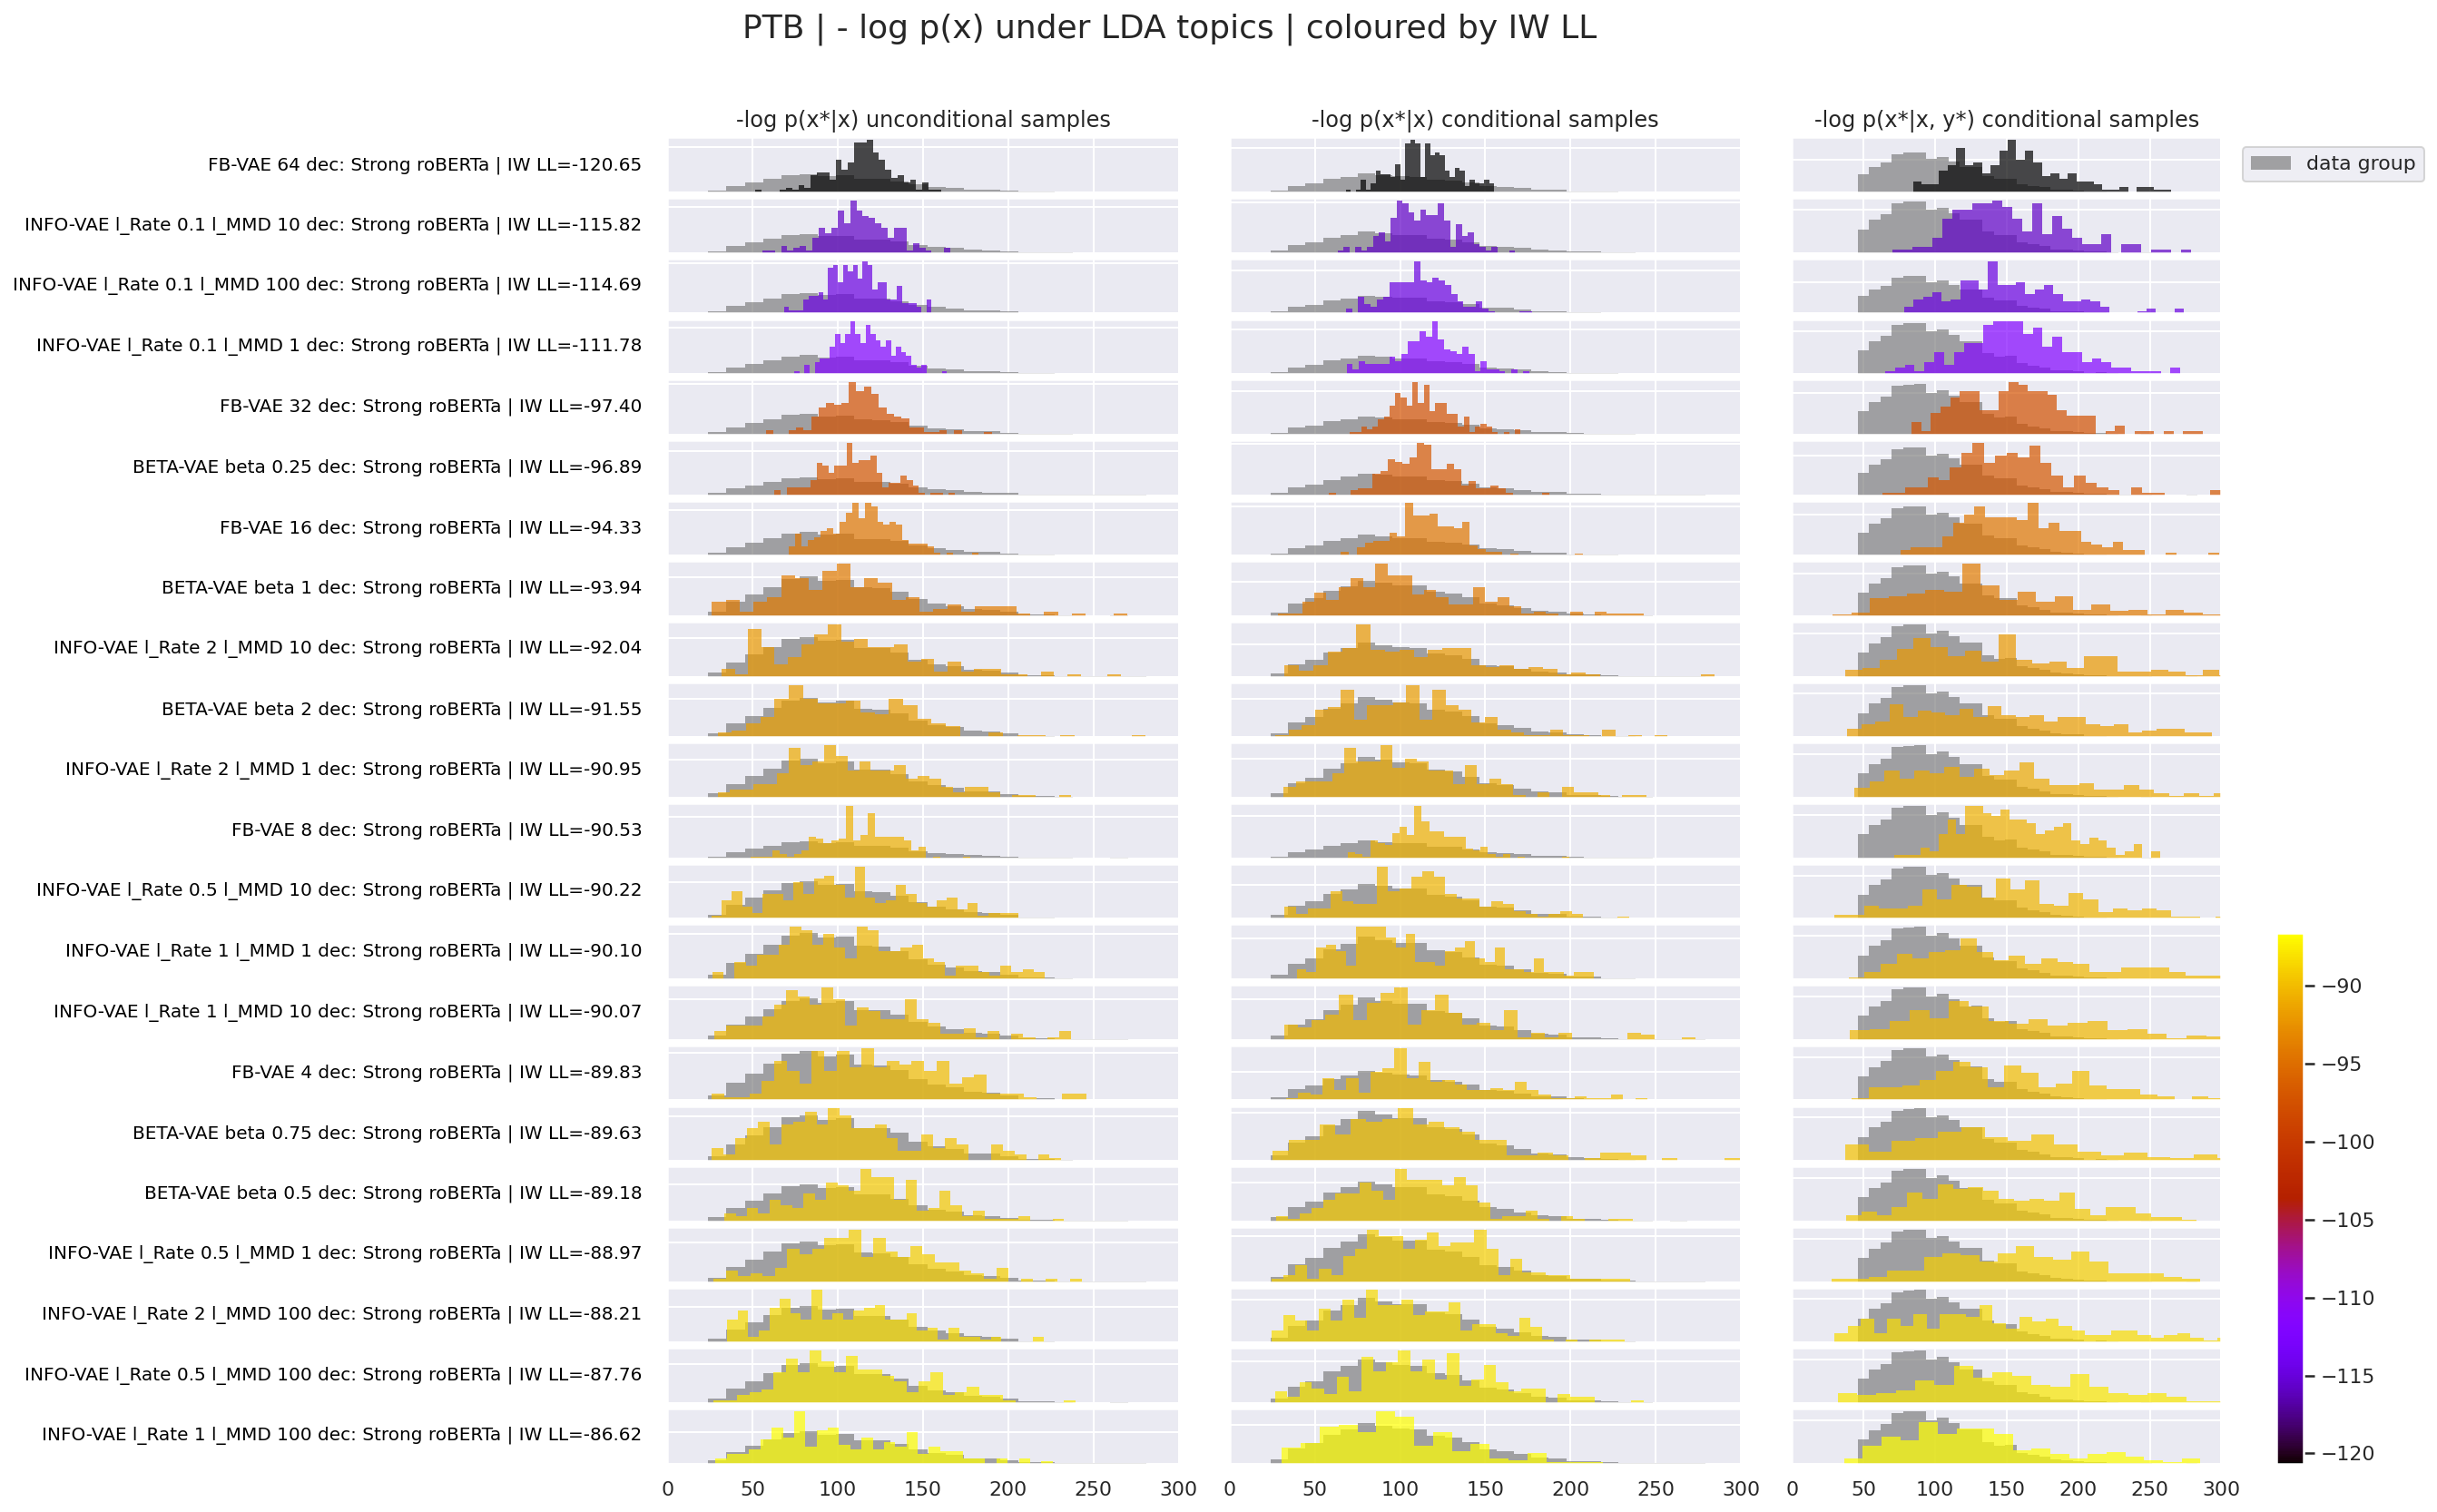

In [13]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

global_stats_df_filter = global_stats_df[global_stats_df["IW LL"] > -250]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="IW LL", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.05,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)

Rows: 22, cols: 3, every: 1, n_groups: 22


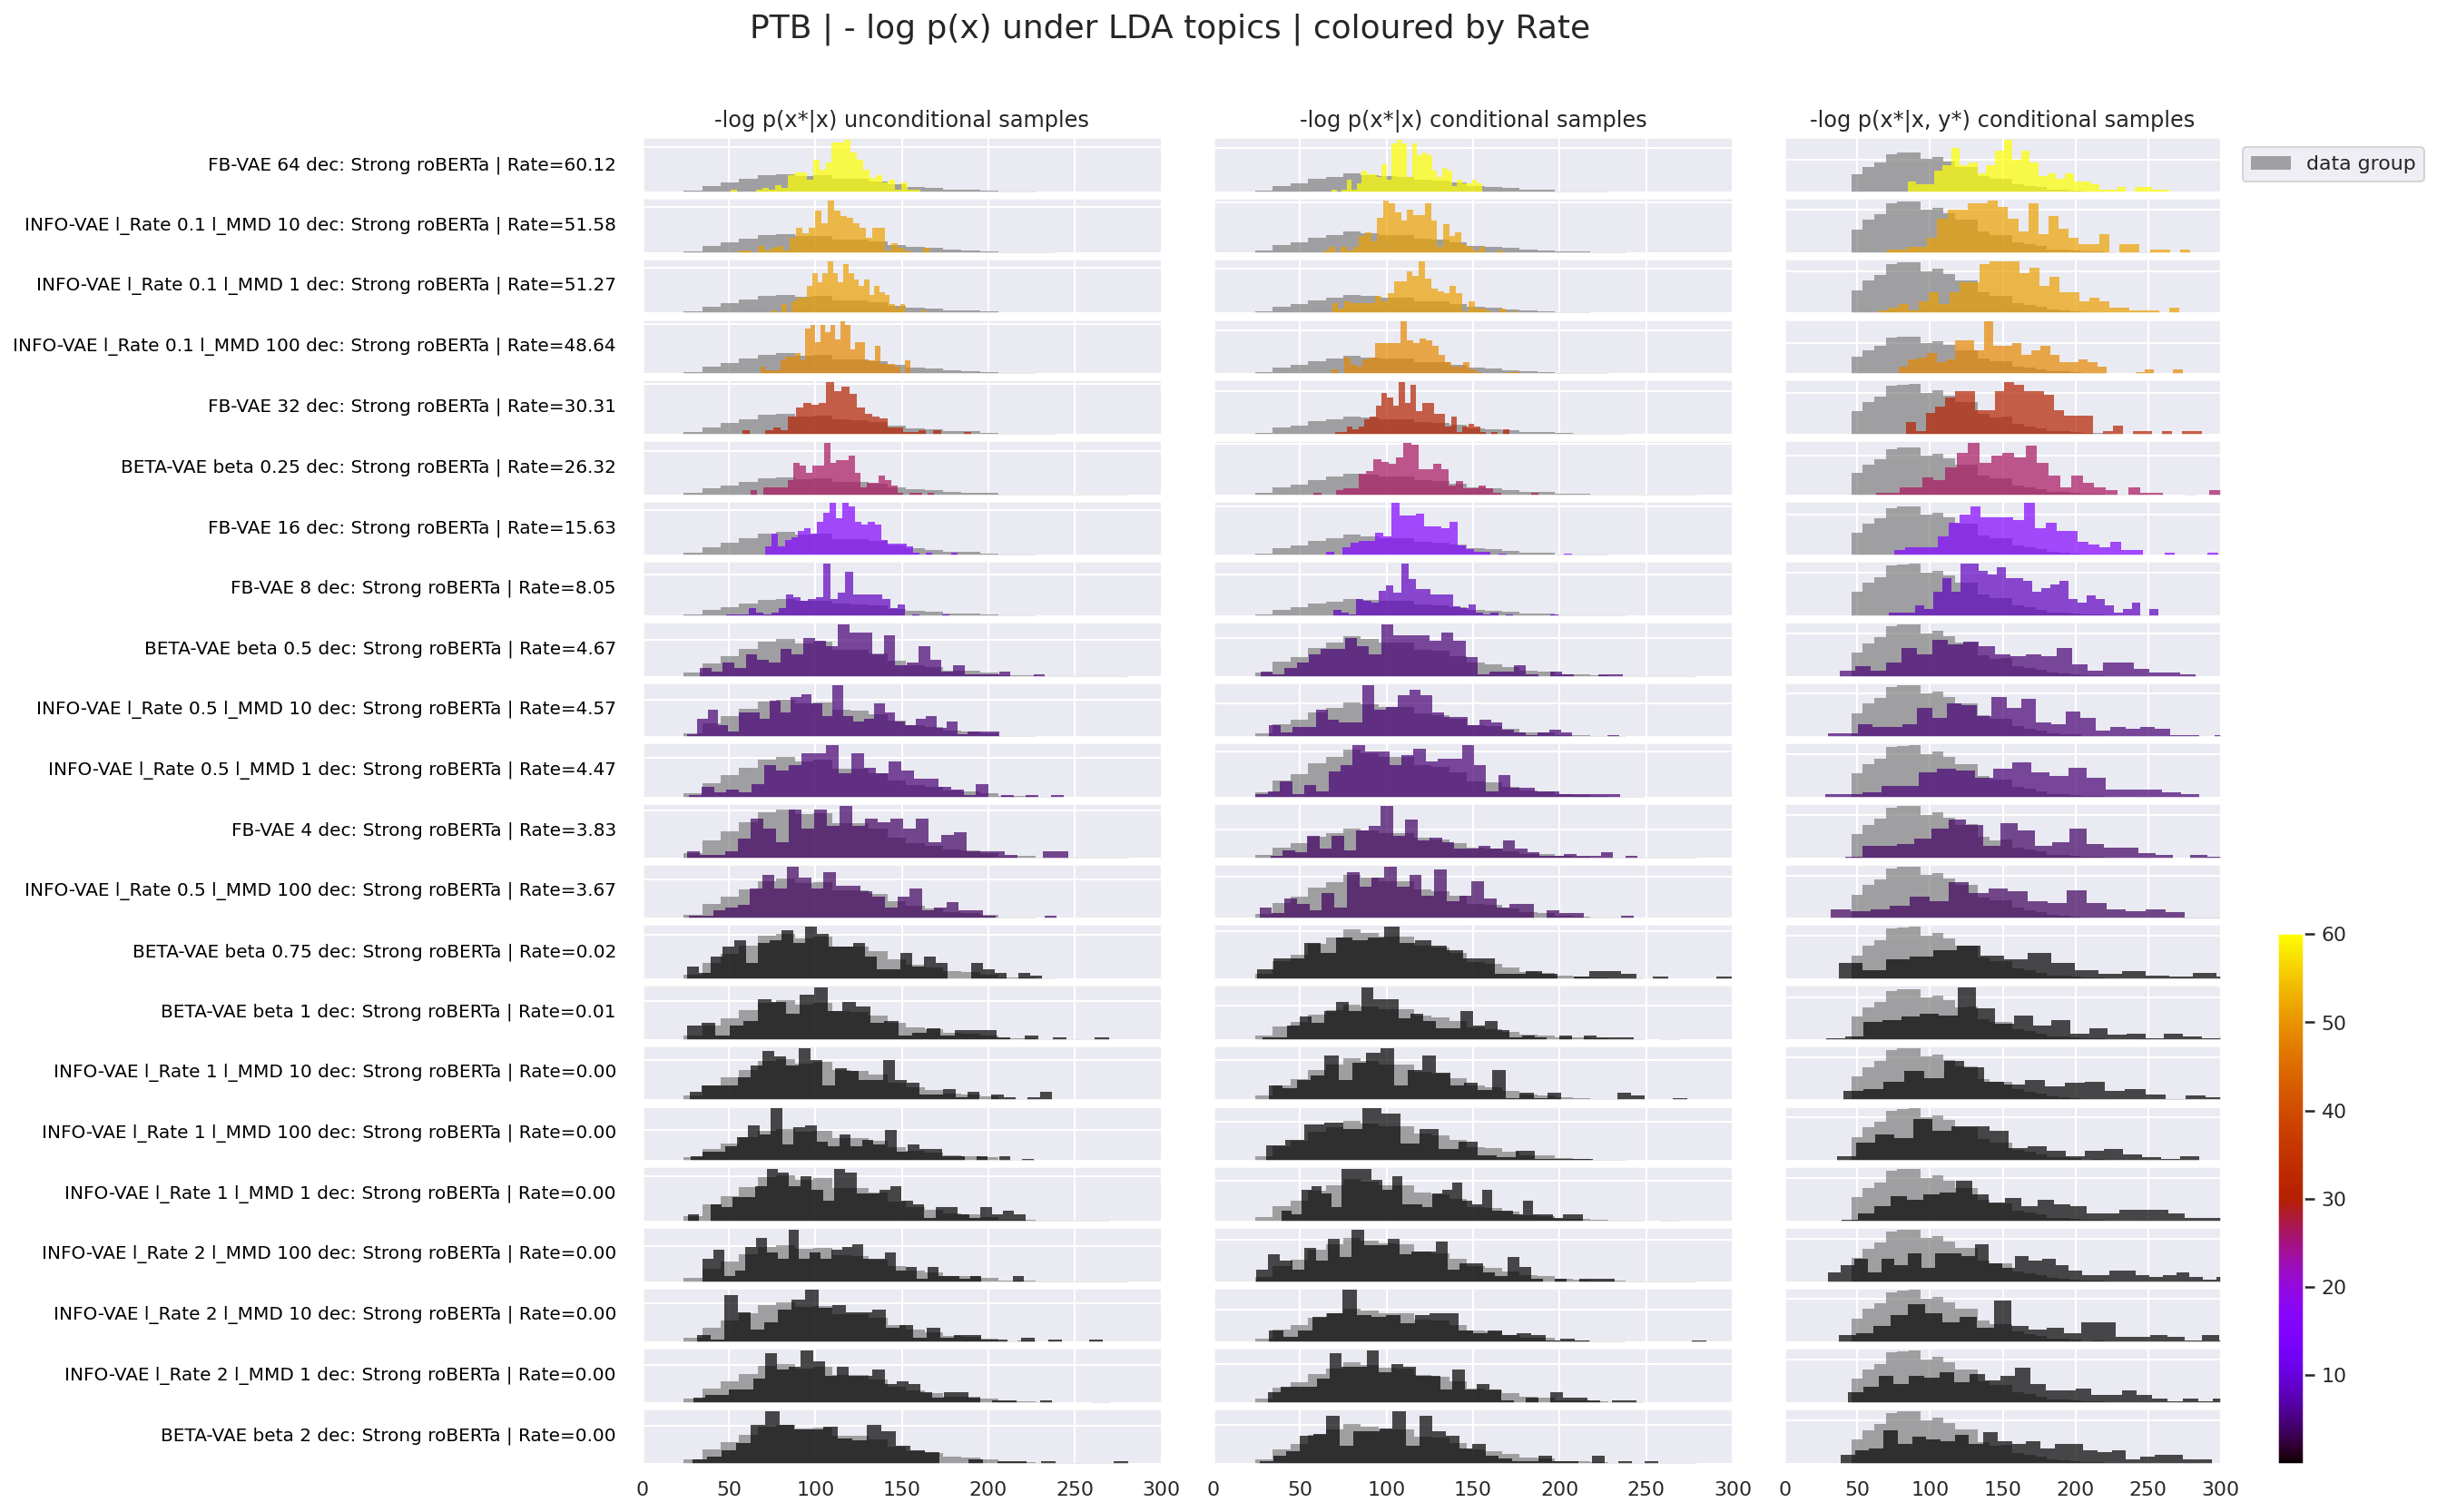

In [50]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

global_stats_df_filter = global_stats_df[global_stats_df["kl_prior_post"] < 70]
print("Leaving out autoencoder run with high R.")

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="Rate", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.05,
                                         subsample_nrows=None, 
                                         sort_ascend=False, 
                                         row_height=0.5)

# Analyse surprisal distribution with a DP mixture of truncated normals

STAT: unconditional_unconditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
max_y 280.65512
max_y 280.65512
Warning, values higher than 1000.0, filtering those out


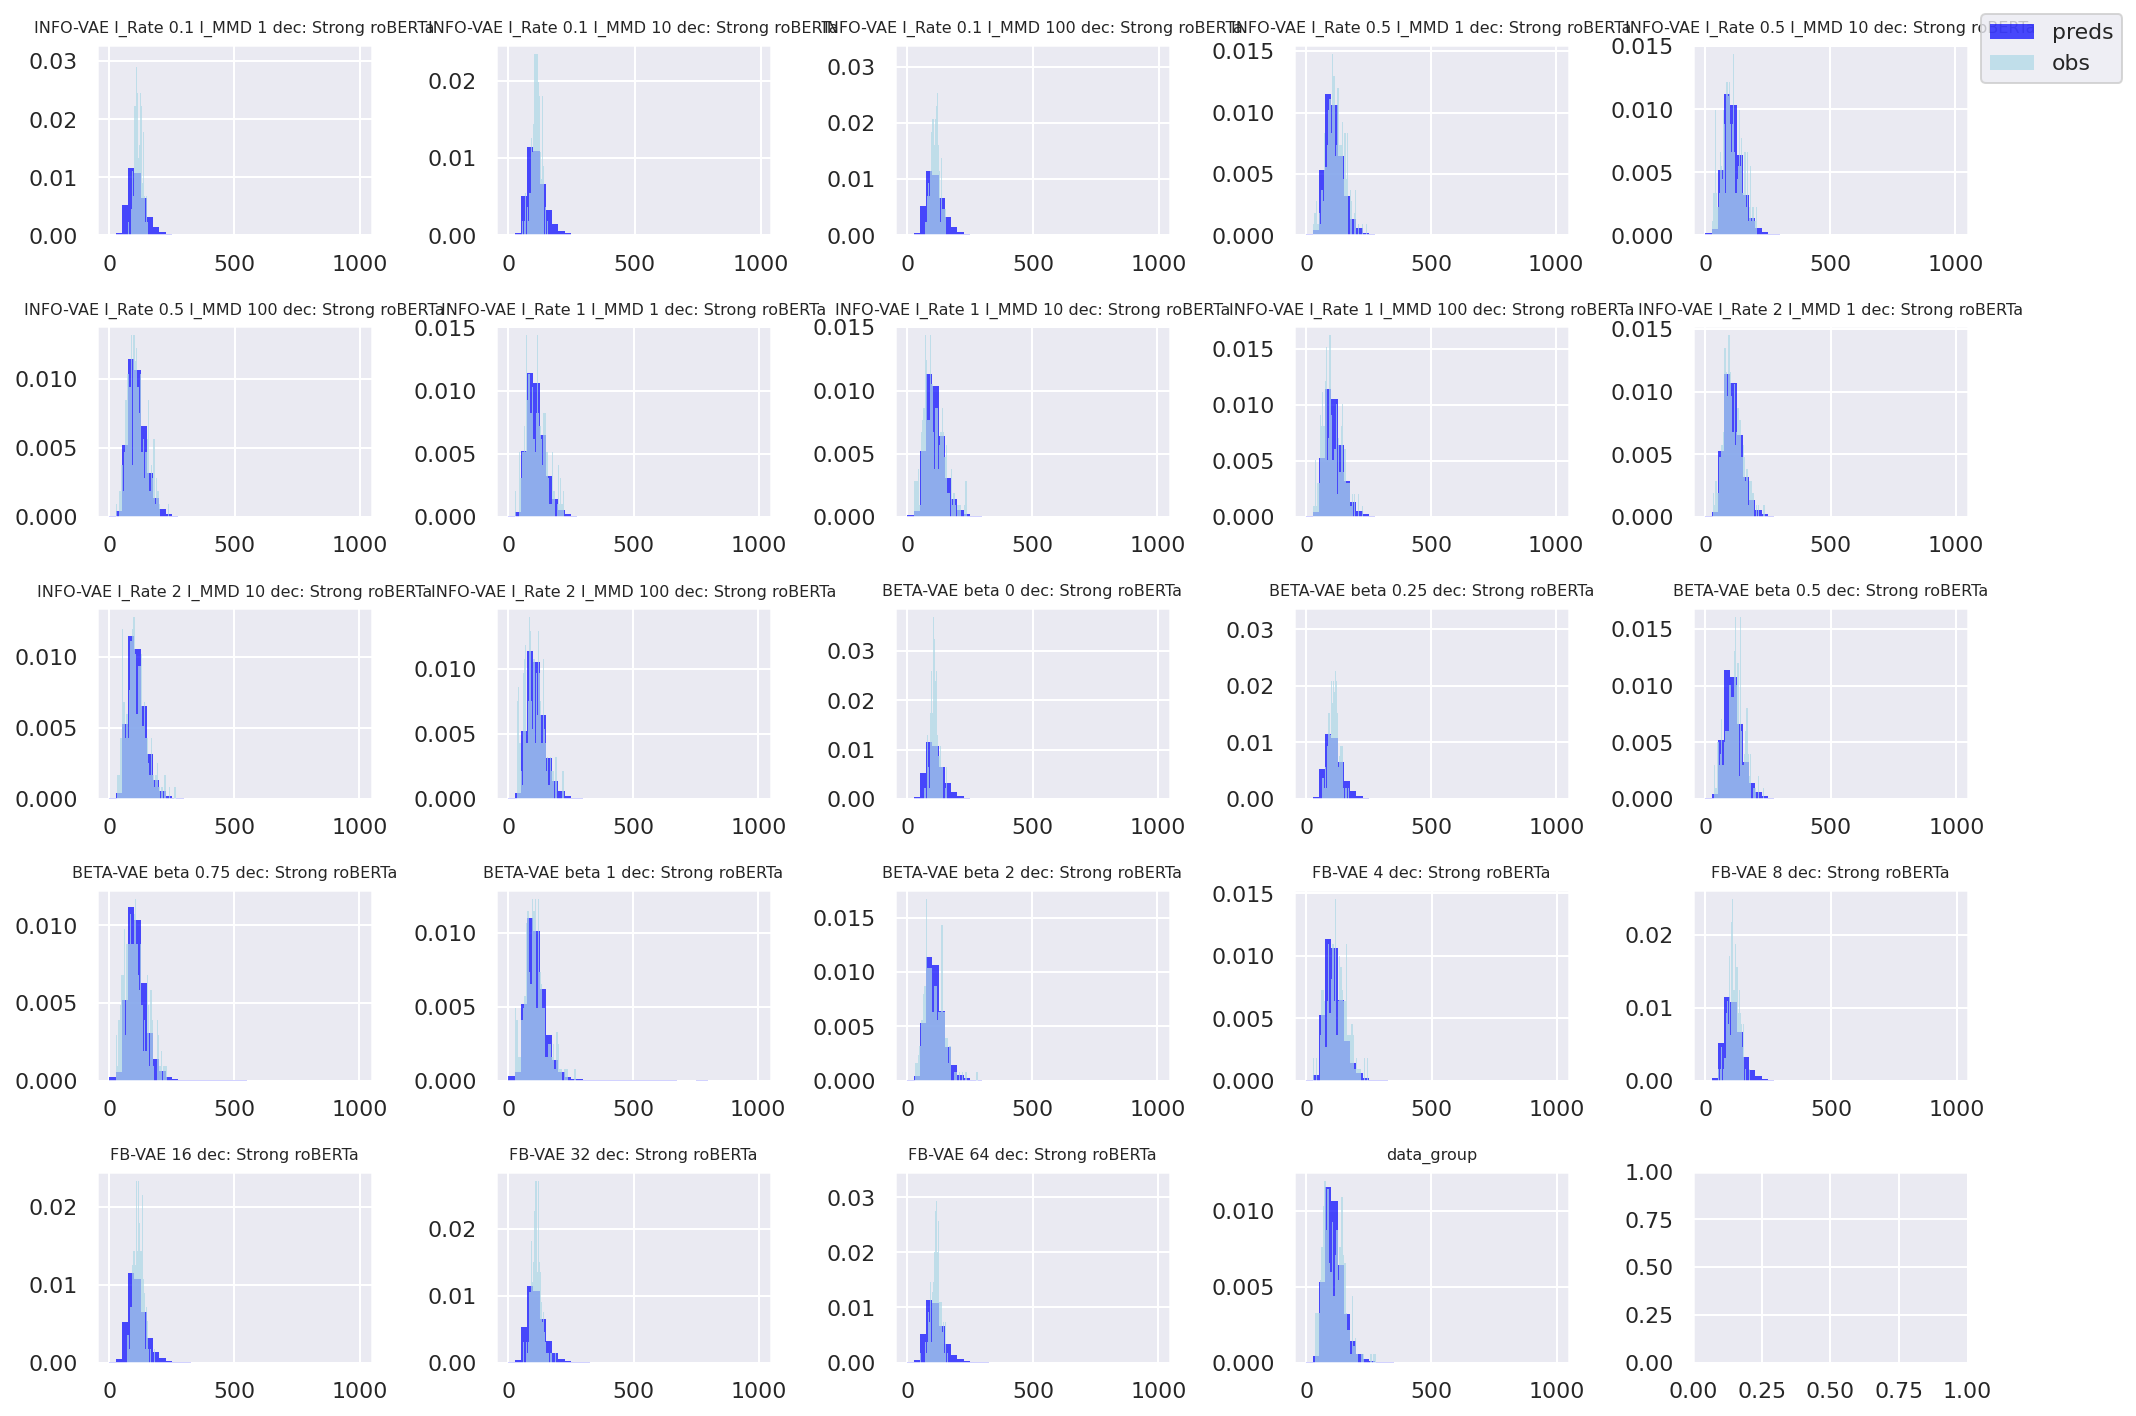

----------------------------------------
STAT: unconditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
max_y 363.2007
max_y 363.2007
Warning, values higher than 1000.0, filtering those out


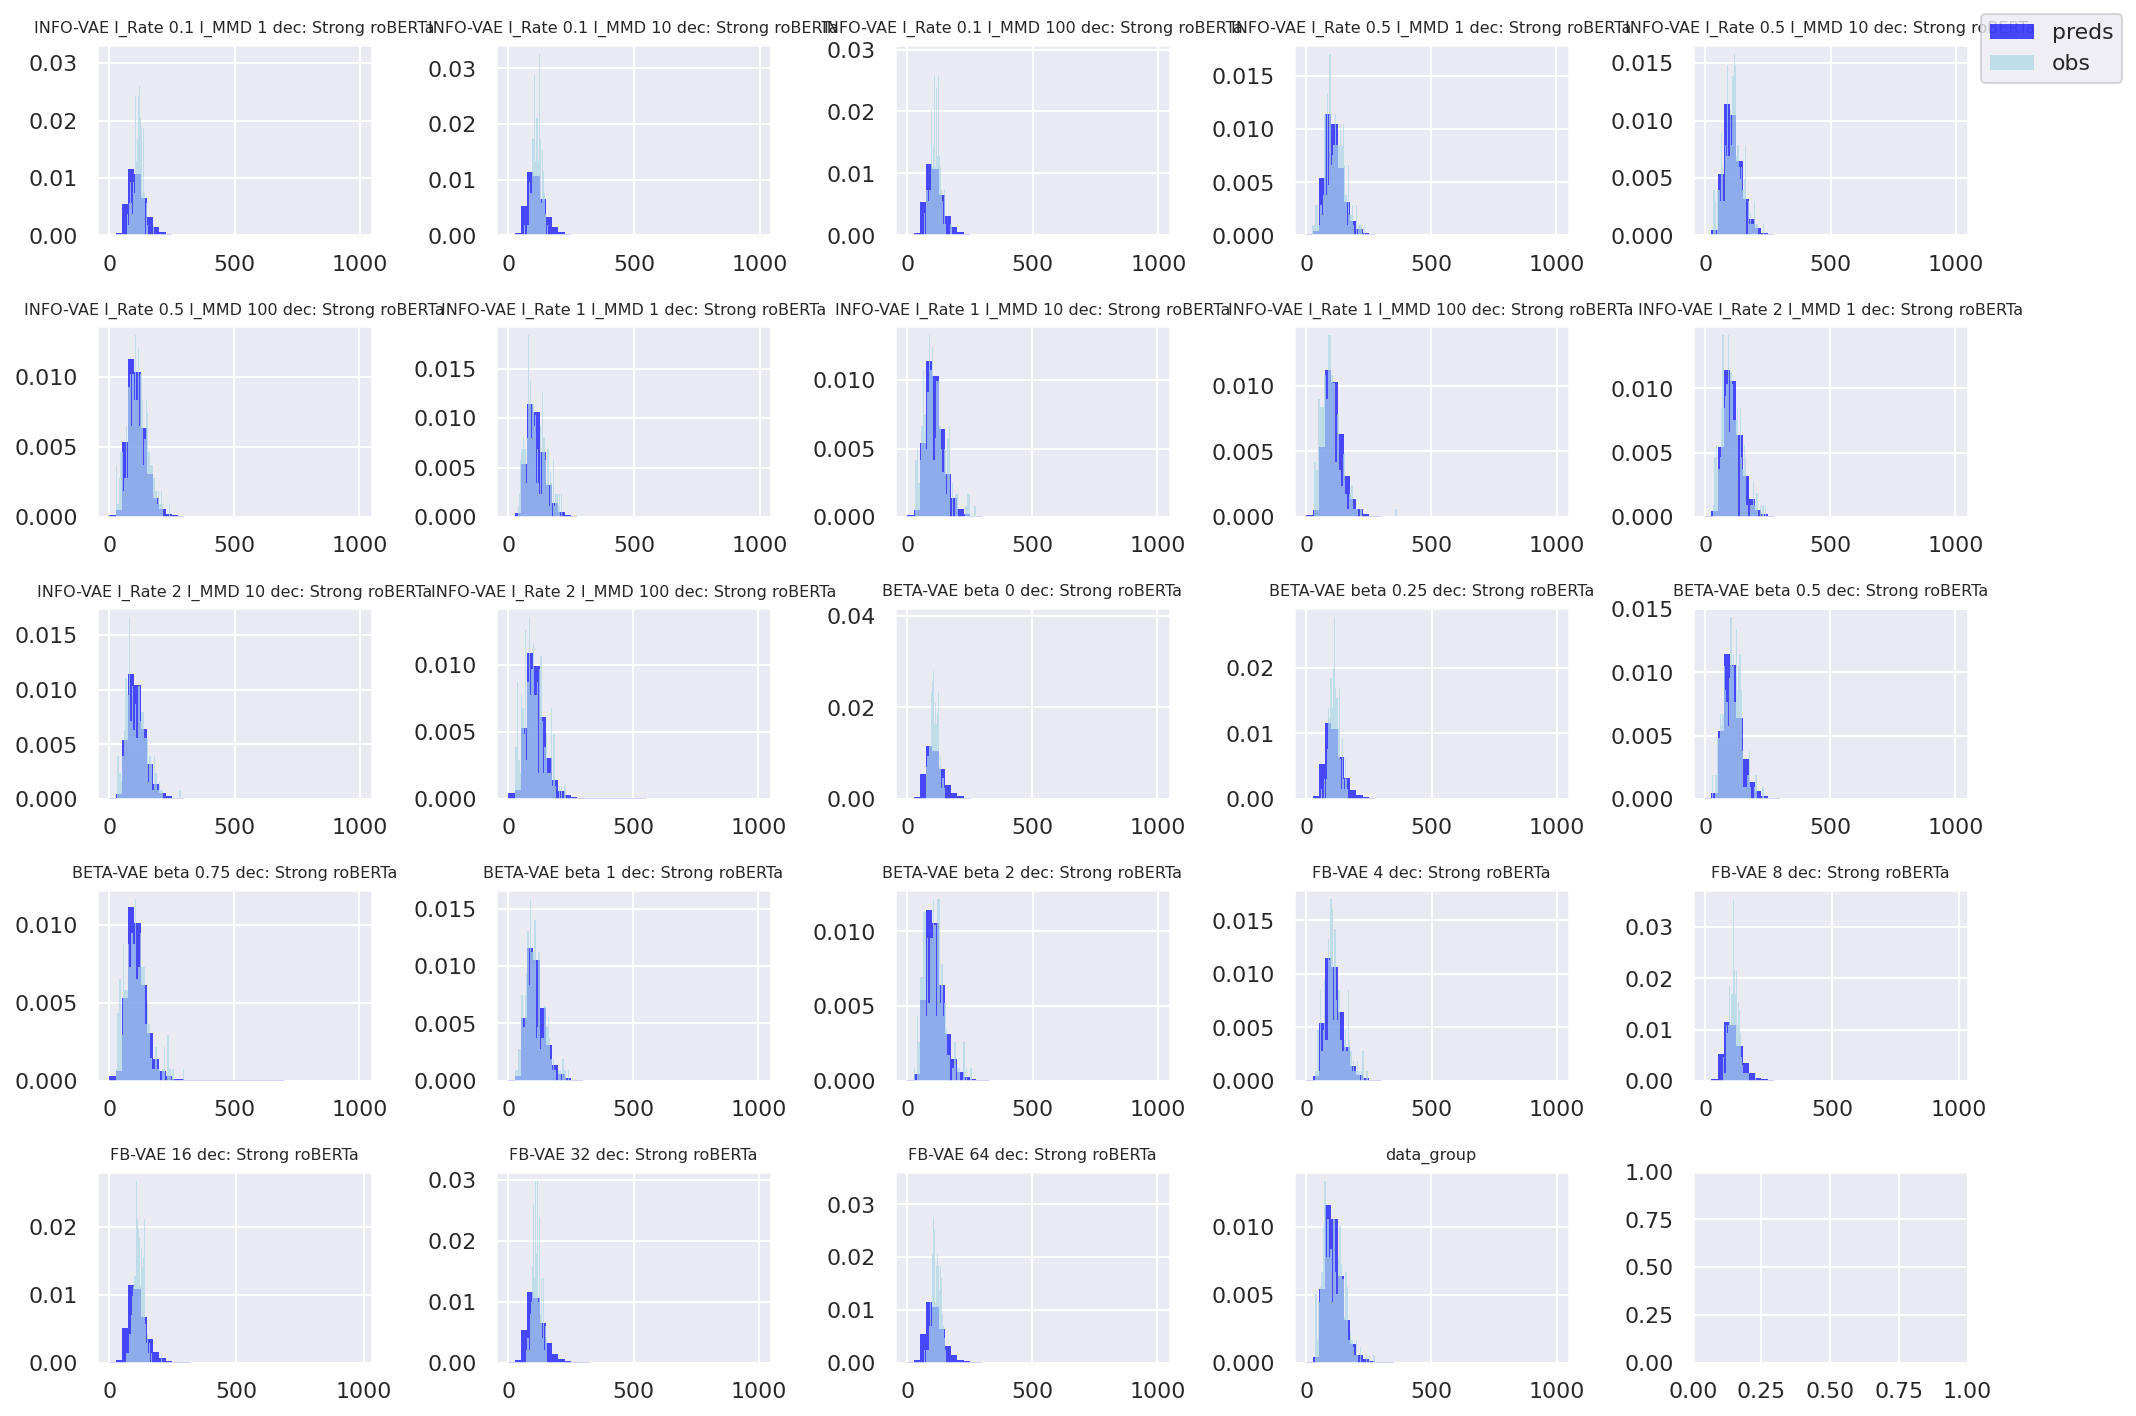

----------------------------------------
STAT: conditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
max_y 524.2148342132568
max_y 524.2148342132568
Warning, values higher than 1000.0, filtering those out


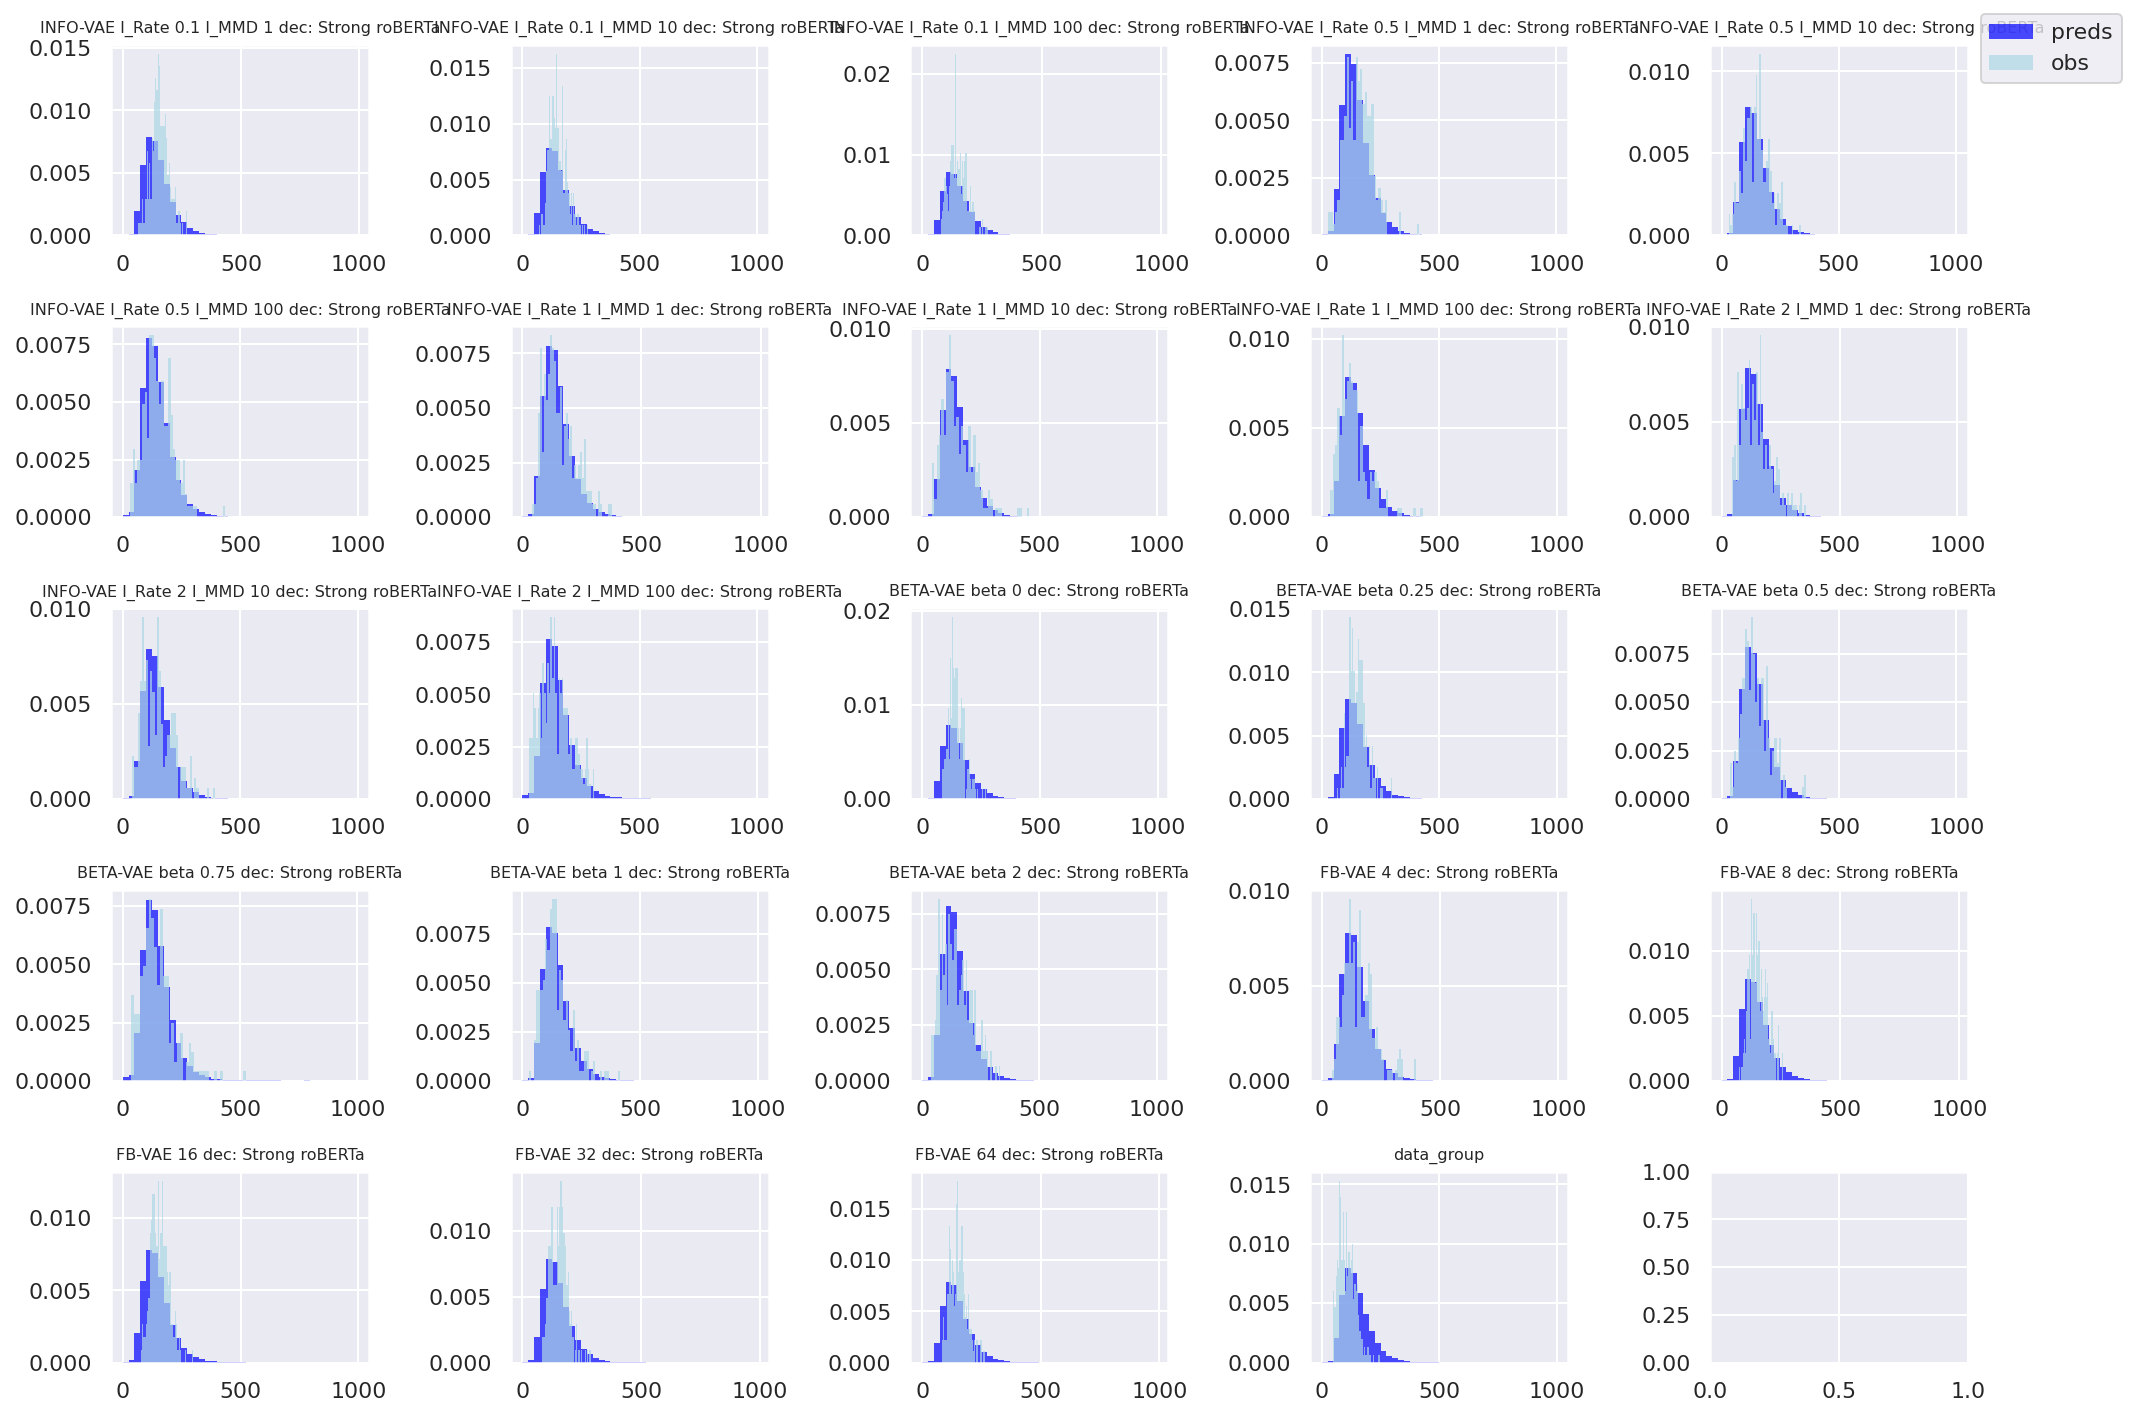

----------------------------------------


In [19]:
perform_prior_predictive_checks = False
perform_posterior_predictive_checks = True

MAX_SAMPLES_PER_GROUP = 300

NUM_COMPS = 5
NUM_CHAINS = 1
NUM_WARMUP = 100
NUM_SAMPLES = 1200

DP_ALPHA = 1.0
OBS_DIST = "log_normal"
# OBS_DIST = "truncated_normal"
TRUNCATED_LOW = 0.0

MAX_GROUPS = 100 # all
MAX_PLOT_CHECK = 1
SKIP_WEAK = True

FIT_SURPRISAL_DPS = False

if FIT_SURPRISAL_DPS:
    dp_mixtures = dict()
    #dp_mixtures = pickle.load(open(SAVE_SURPRISAL_DP_FILE, "rb"))
    
    stats = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    for stat_name in stats:
        print(stat_name)
        
        if stat_name in dp_mixtures:
            print("Did this one already, continuing..")
            continue

        group_names = []
        observations = []
        
        c = 0
        for i, (k, v) in enumerate(surprisal_values.items()):
            if "weak-m" not in k.lower():
                group_names.append(k)
                observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))
                
                c += 1
                if c == MAX_GROUPS:
                    break
                
        if "data_group" not in group_names:
            group_names.append("data_group")
            observations.append(np.array(surprisal_values["data_group"][stat_name][:MAX_SAMPLES_PER_GROUP]))
            
        print("Number of groups", len(observations))

        dp_mixture = DPMixture(
            group_names, 
            observations, 
            obs_dist=OBS_DIST,
            truncated_normal_low=TRUNCATED_LOW,
            DP_alpha=DP_ALPHA, 
            num_comps=NUM_COMPS, 
            num_samples=NUM_SAMPLES, 
            num_chains=NUM_CHAINS, 
            num_warmup=NUM_WARMUP
        )
    
        if perform_prior_predictive_checks:
            print("-"*40)
            print("PRIOR PREDICTIVE PLOTS")
            prior_samples = dp_mixture.draw_prior_predictions(num_samples=400)
            
            print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
            
            surprisal_dp_plot_checks(dp_mixture, prior_samples["y"], plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
                
            print("-"*40)
            
        dp_mixture.run()

        dp_mixtures[stat_name] = dp_mixture
        
        if perform_posterior_predictive_checks:
            print("-"*40)
            print("POSTERIOR PREDICTIVE PLOTS")
            
            posterior_samples = dp_mixture.draw_posterior_predictions()
            samples = posterior_samples["y"]
            
            surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
            print("-"*40)
    
        pickle.dump(dp_mixtures, open(SAVE_SURPRISAL_DP_FILE, "wb"))
    
else:
    if os.path.exists(SAVE_SURPRISAL_DP_FILE):
        dp_mixtures = pickle.load(open(SAVE_SURPRISAL_DP_FILE, "rb"))
        
        for stat_name, dp_mixture in dp_mixtures.items():
            print("STAT:", stat_name)
            if perform_posterior_predictive_checks:
                print("-"*40)
                print("POSTERIOR PREDICTIVE PLOTS")

                posterior_samples = dp_mixture.draw_posterior_predictions()
                samples = posterior_samples["y"]

#                 surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
#                 plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
                plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
                print("-"*40)
    else:
        print(f"No DPs saved in SAVE_SURPRISAL_DP_FILE={SAVE_SURPRISAL_DP_FILE}, set FIT_SURPRISAL_DPS=True to re-run.")

In [66]:

def plot_all_groups_preds_obs(self, prior=False, num_prior_samples=400, filter_vals_higher=1e6):
    if prior:
        preds = self.draw_prior_predictions(num_samples=num_prior_samples)["y"]
    else:
        preds = self.draw_posterior_predictions()["y"]

    if (preds > filter_vals_higher).any():
        print(f"Warning, values higher than {filter_vals_higher}, filtering those out")

    N_groups = len(self.group_names)

    ncols = 5
    nrows = int(np.ceil(N_groups / 5))

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 2 * nrows), sharey=True, sharex=True)

    for g in range(N_groups):
        row, col = g // ncols, g % ncols

        preds_g = preds[:, self.obs_g == g]
#         preds = preds.transpose(1, 0)
#         preds_g = preds[self.obs_g == g, :]
        obs_g = self.obs_y[self.obs_g == g]

        preds_g = np.array(preds_g).flatten()
        if (preds_g > filter_vals_higher).any():
            preds_g = preds_g[preds_g < filter_vals_higher]

        axs[row, col].hist(preds_g, bins=40, density=True, lw=0, label="preds", alpha=0.7,
                           color="blue")
        axs[row, col].hist(np.array(obs_g).flatten(), bins=40, density=True, lw=0, label="obs", alpha=0.7,
                           color="lightblue")

        axs[row, col].set_title(self.group_names[g], size=8)

        if (col == ncols - 1) and (row == 0):
            axs[row, col].legend(loc=(1.05, 0.8))

    plt.tight_layout()
    plt.show()



obs_g (4900,)
max_y 280.65512
max_y 280.65512
Warning, values higher than 1000.0, filtering those out


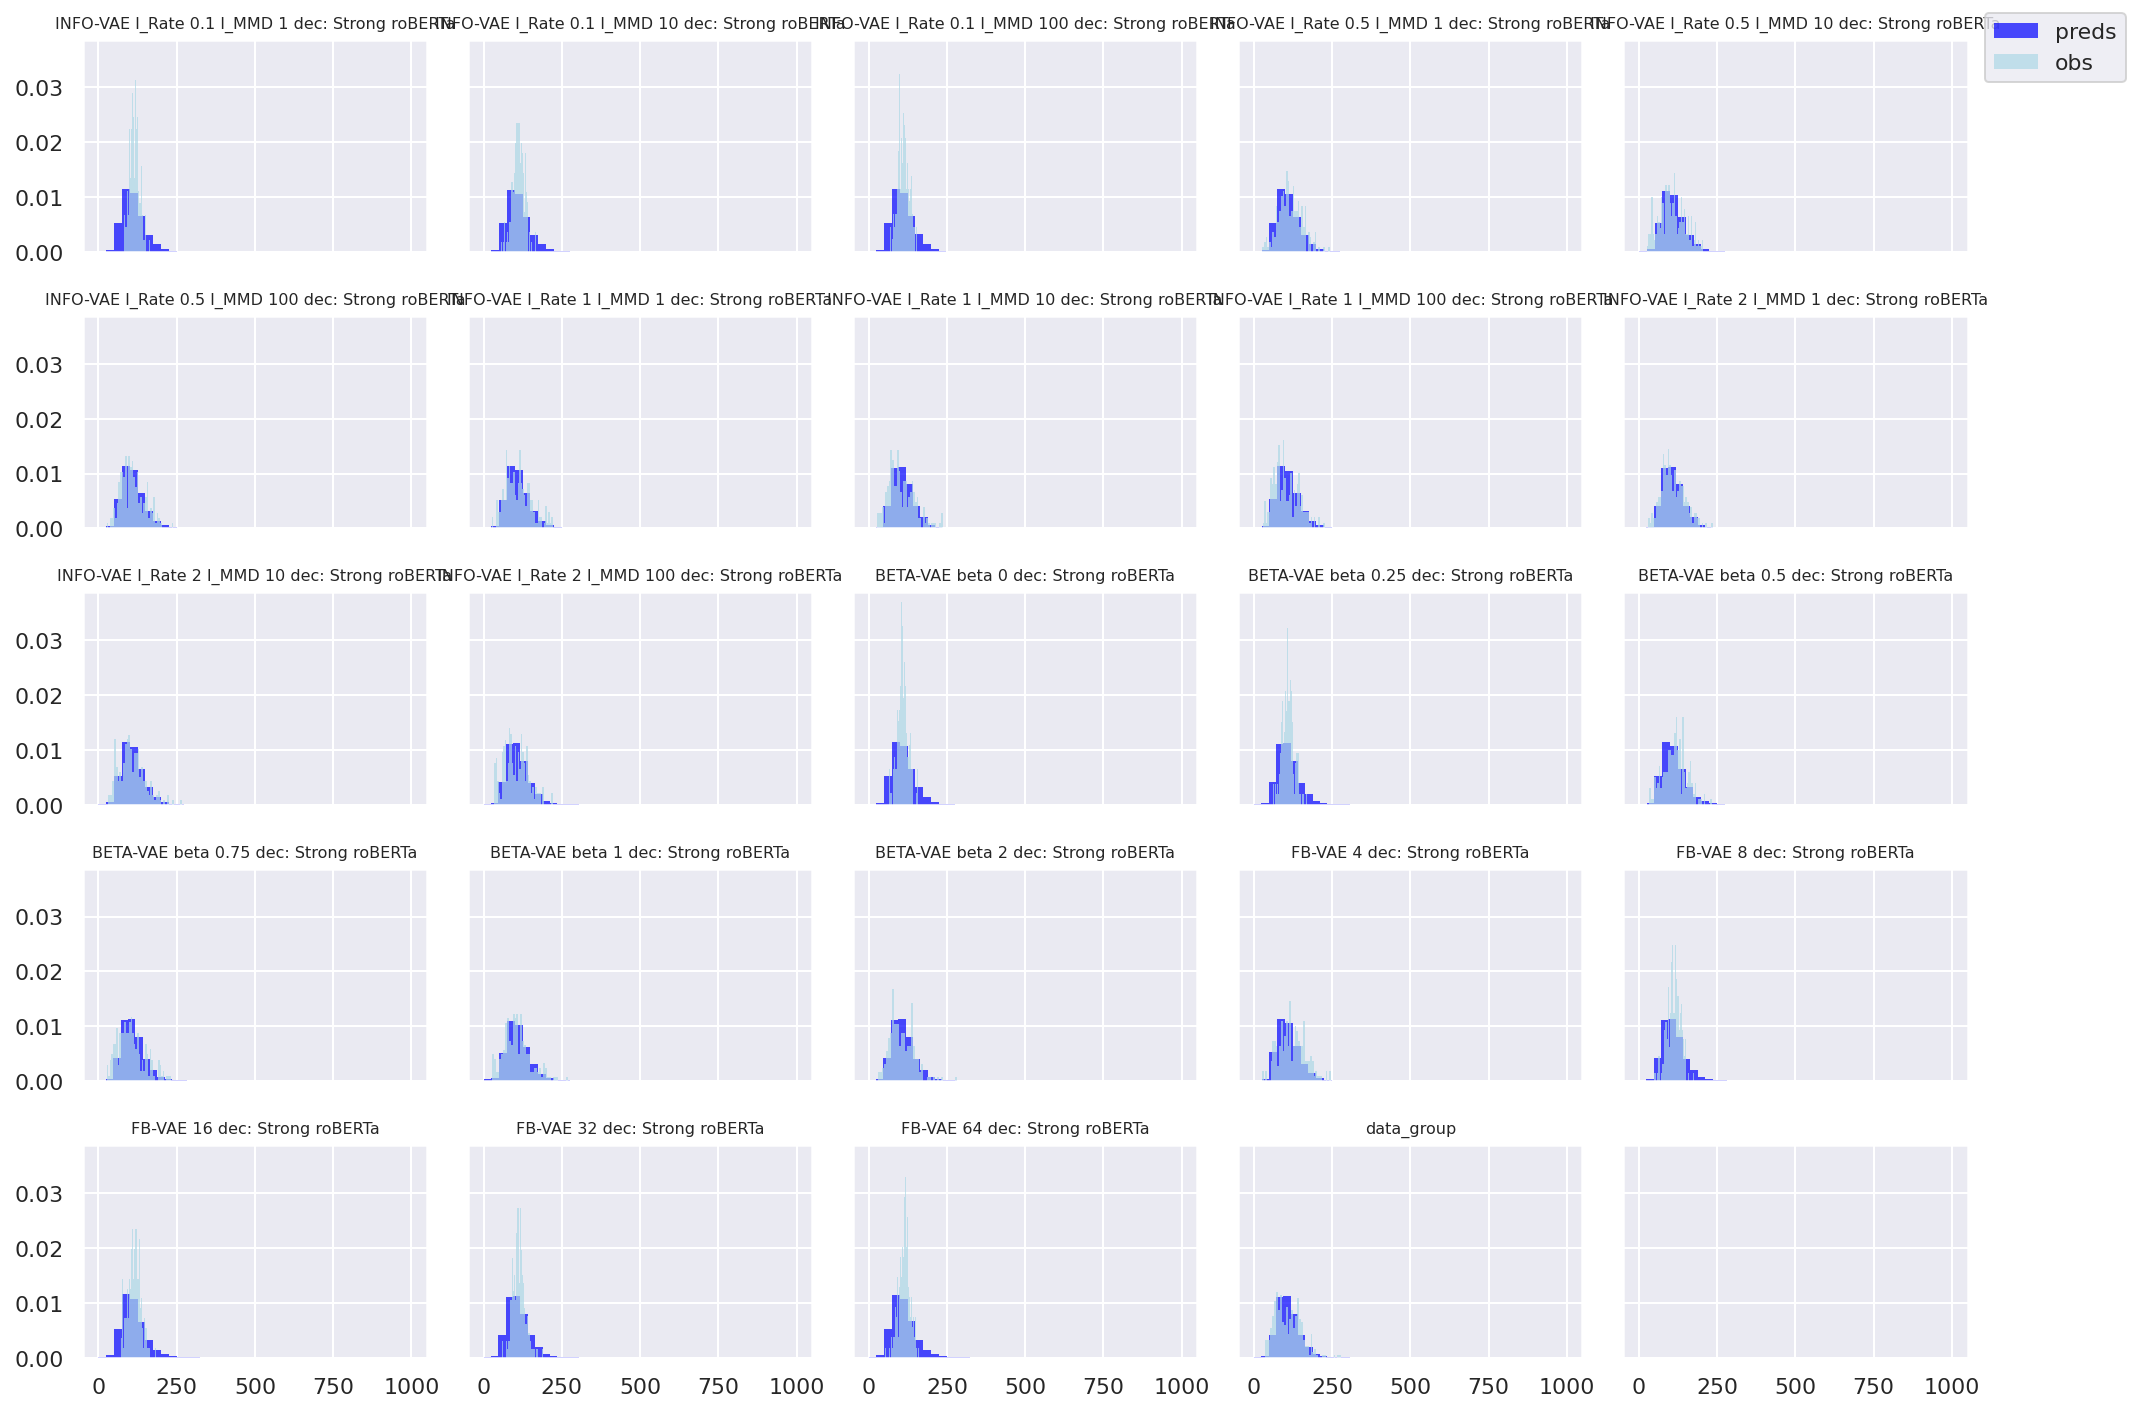

post_y (1200, 4900)
unconditional_unconditional 0 INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(239424,)
unconditional_unconditional 1 INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(239441,)
unconditional_unconditional 2 INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(239429,)
unconditional_unconditional 3 INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(238602,)
unconditional_unconditional 4 INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(236097,)
unconditional_unconditional 5 INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(238793,)
unconditional_unconditional 6 INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(238088,)
unconditional_unconditional 7 INFO-VAE l_Rate 1 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(236679,)
unconditional_unconditional 8 INFO-VAE l_Rate 1 l_MMD 100 dec: Strong roBERTa
(1200, 4900

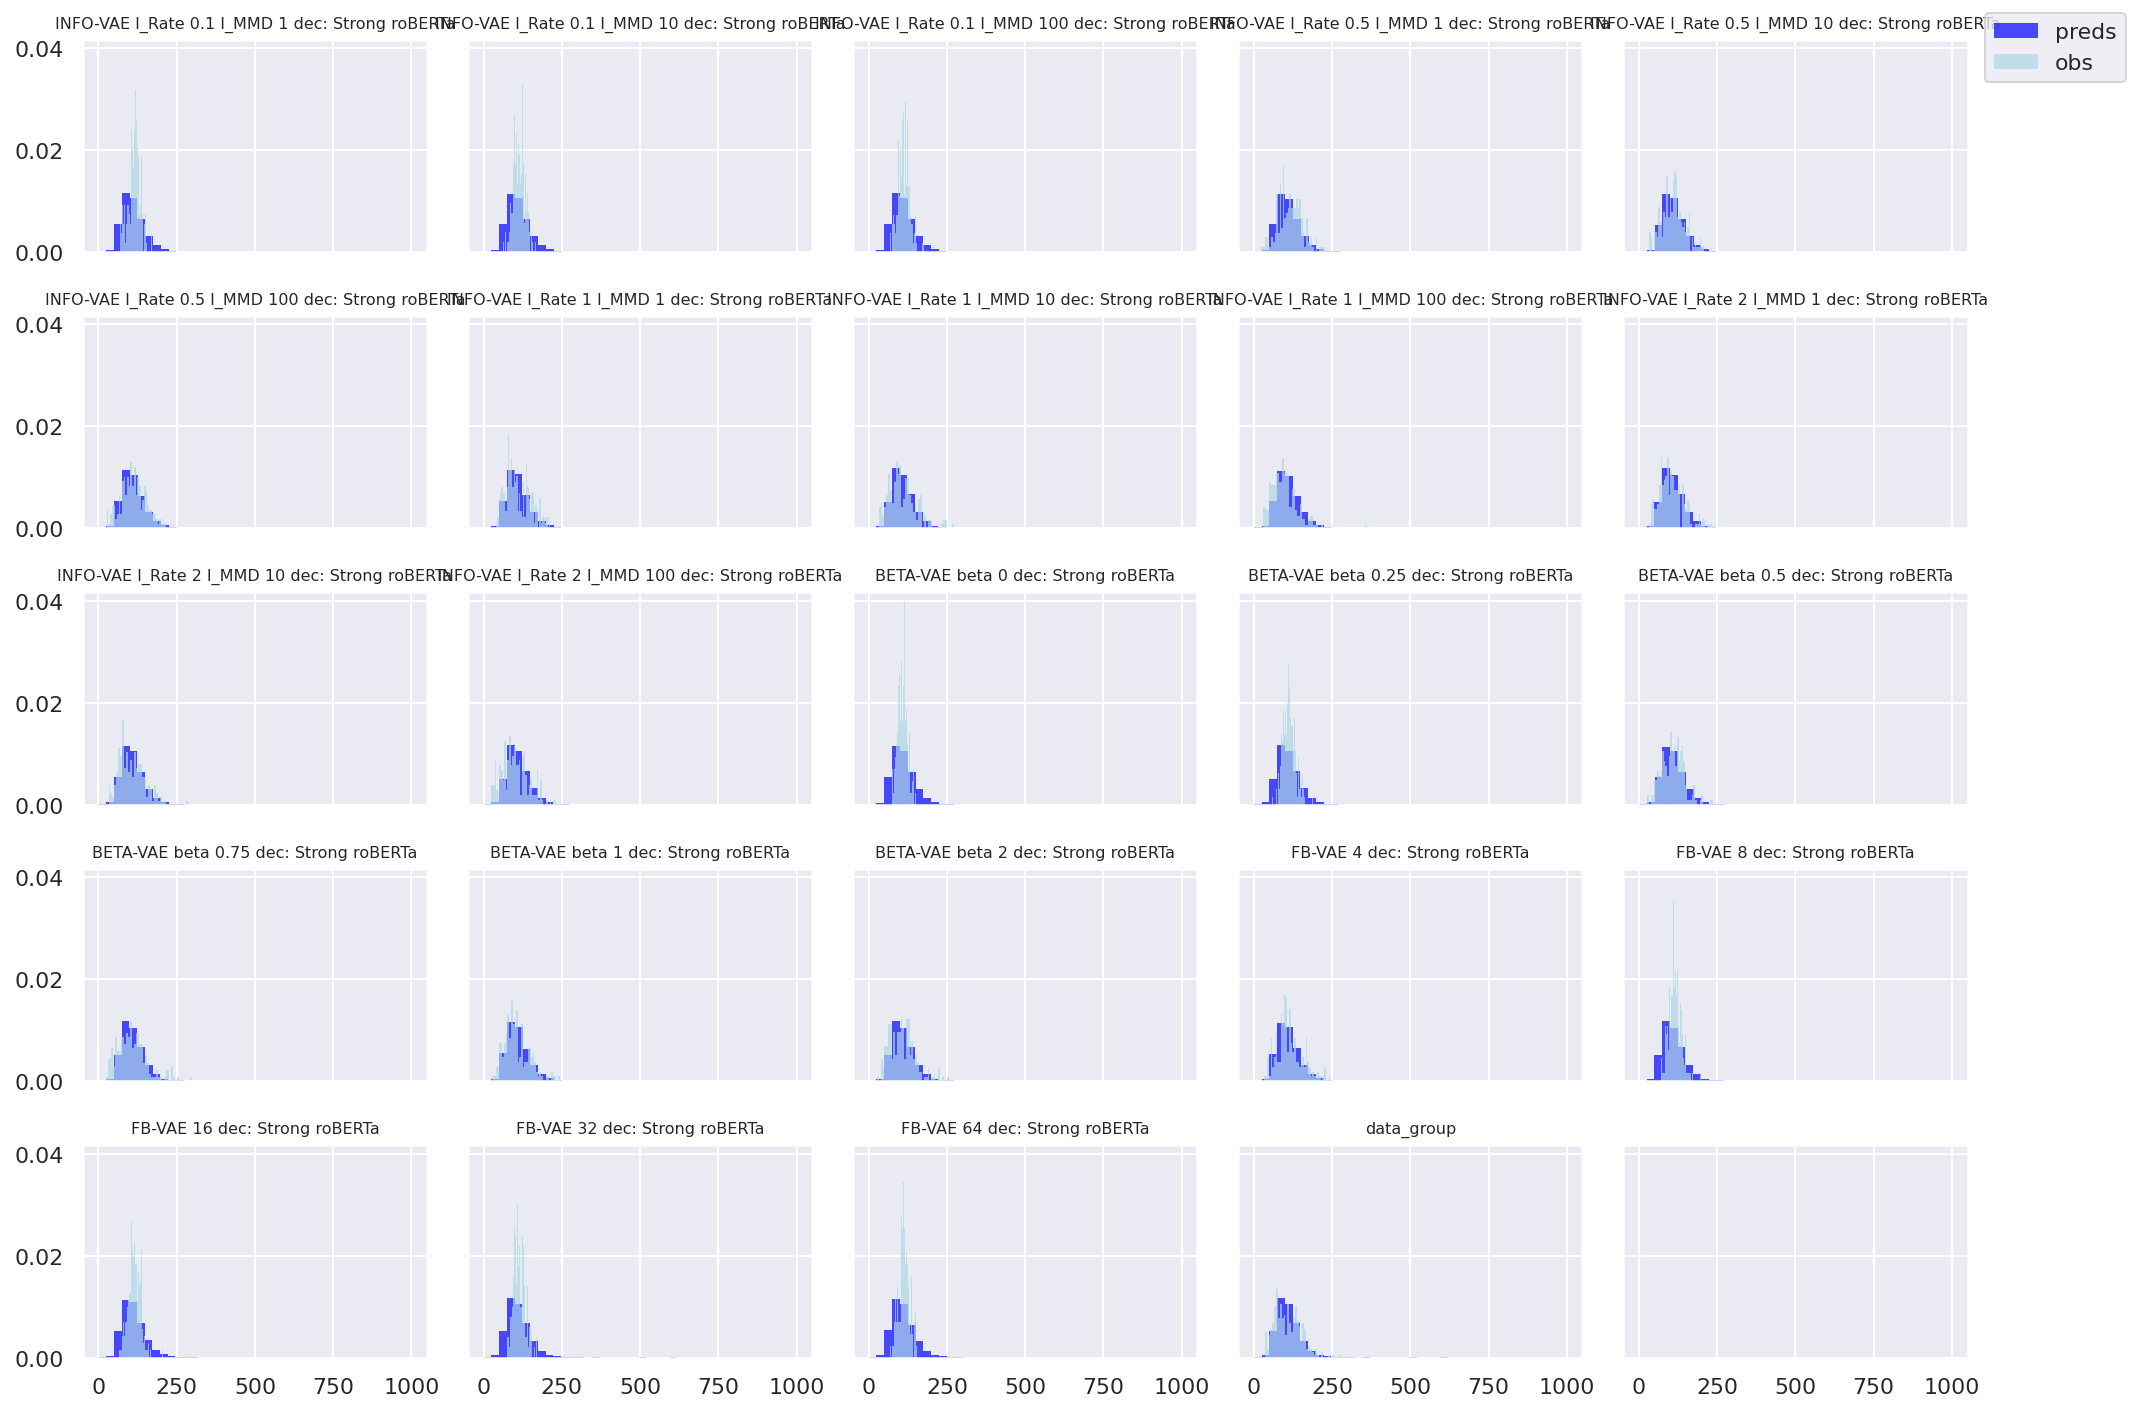

post_y (1200, 4900)
unconditional_conditional 0 INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(239404,)
unconditional_conditional 1 INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(239413,)
unconditional_conditional 2 INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(239410,)
unconditional_conditional 3 INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(238429,)
unconditional_conditional 4 INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(238685,)
unconditional_conditional 5 INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(236840,)
unconditional_conditional 6 INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(239234,)
unconditional_conditional 7 INFO-VAE l_Rate 1 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(237603,)
unconditional_conditional 8 INFO-VAE l_Rate 1 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(23665

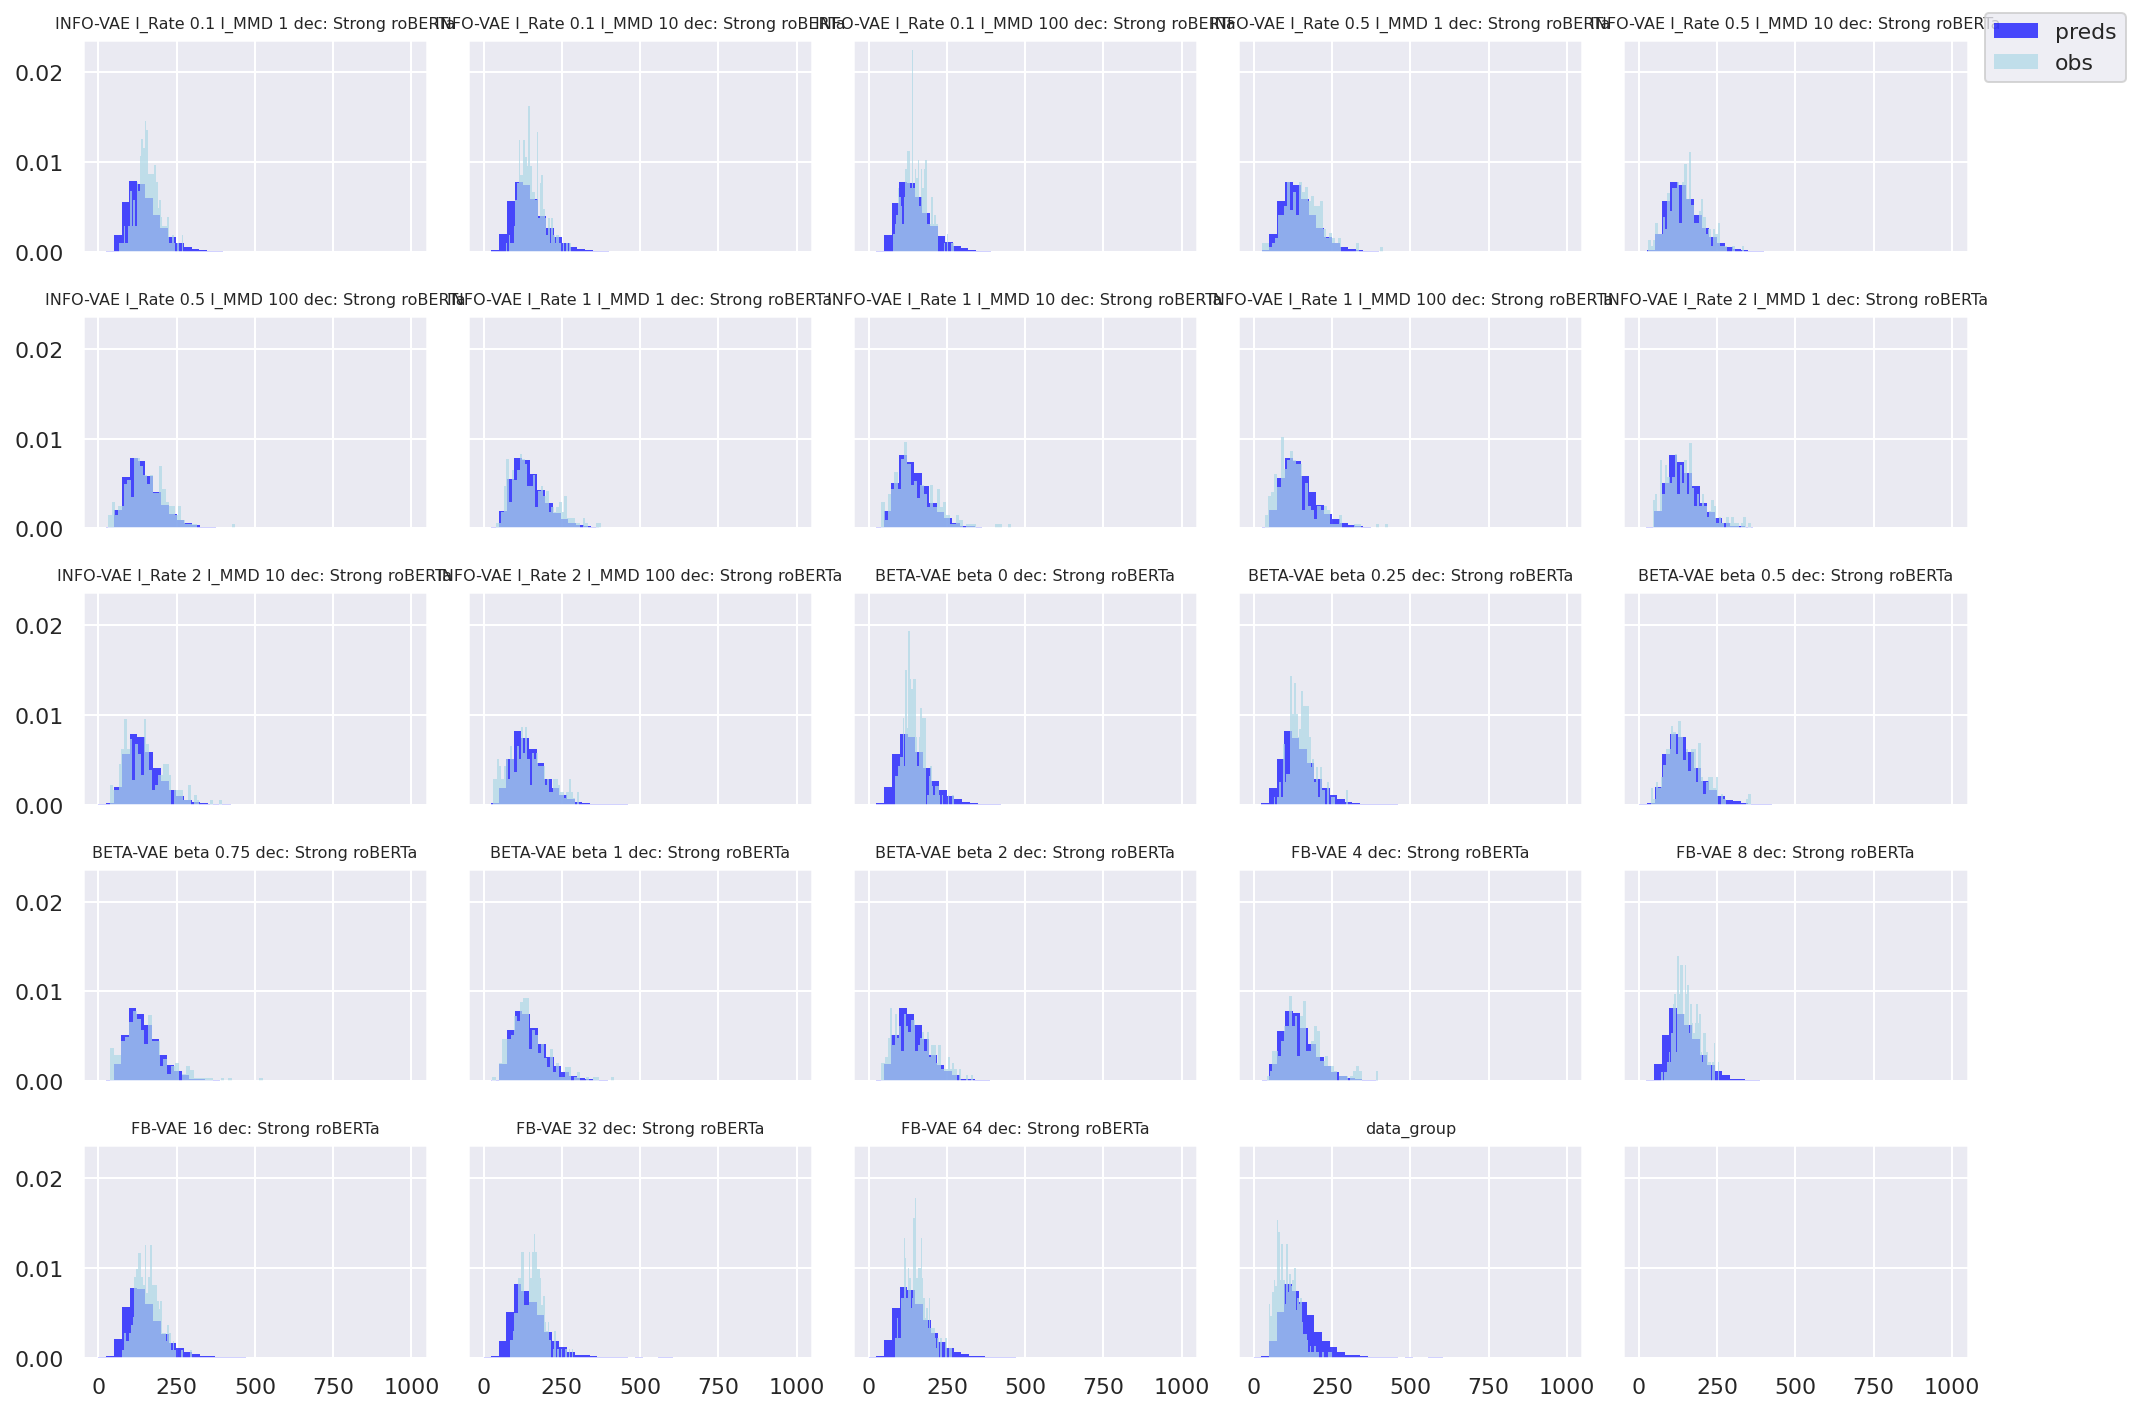

post_y (1200, 4900)
conditional_conditional 0 INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(239301,)
conditional_conditional 1 INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(239305,)
conditional_conditional 2 INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(239377,)
conditional_conditional 3 INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(238421,)
conditional_conditional 4 INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(238665,)
conditional_conditional 5 INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(237437,)
conditional_conditional 6 INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
(1200, 4900) (240000,)
(239136,)
conditional_conditional 7 INFO-VAE l_Rate 1 l_MMD 10 dec: Strong roBERTa
(1200, 4900) (240000,)
(238813,)
conditional_conditional 8 INFO-VAE l_Rate 1 l_MMD 100 dec: Strong roBERTa
(1200, 4900) (240000,)
(238739,)
conditional_co

In [67]:
res_dict = dict()

for stat_name, dp_mixture in dp_mixtures.items():
    
    print("obs_g", dp_mixture.obs_g.shape)
    
    # [N_s, N_x_all]
    post_y = np.array(dp_mixture.draw_posterior_predictions()["y"])
    
    plot_all_groups_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
    
    print("post_y", post_y.shape)
    
    for group_idx, group_name in enumerate(dp_mixture.group_names):
        print(stat_name, group_idx, group_name)
        
        if group_name not in res_dict:
            res_dict[group_name] = dict()
        
        post_y_g = post_y[:, dp_mixture.obs_g == group_idx].flatten()
        
        print(post_y.shape, post_y_g.shape)
        post_y_g = post_y_g[post_y_g < 1000]
        print(post_y_g.shape)
        
#         plt.title(f"{group_idx} {group_name}")
#         plt.hist(post_y_g, bins=30, density=True)
#         plt.show()
        
#         post_y_g = post_y[dp_mixture.obs_g == group_idx].flatten()
        
#         post_y_g = post_y_g[post_y_g > 0]
#         post_y_g = post_y_g[post_y_g < 1000]
        
#         print(len(post_y_g))
        
        res_dict[group_name][stat_name] = post_y_g

conditional_conditional
max_y 524.2148342132568
Warning, values higher than 1000.0, filtering those out


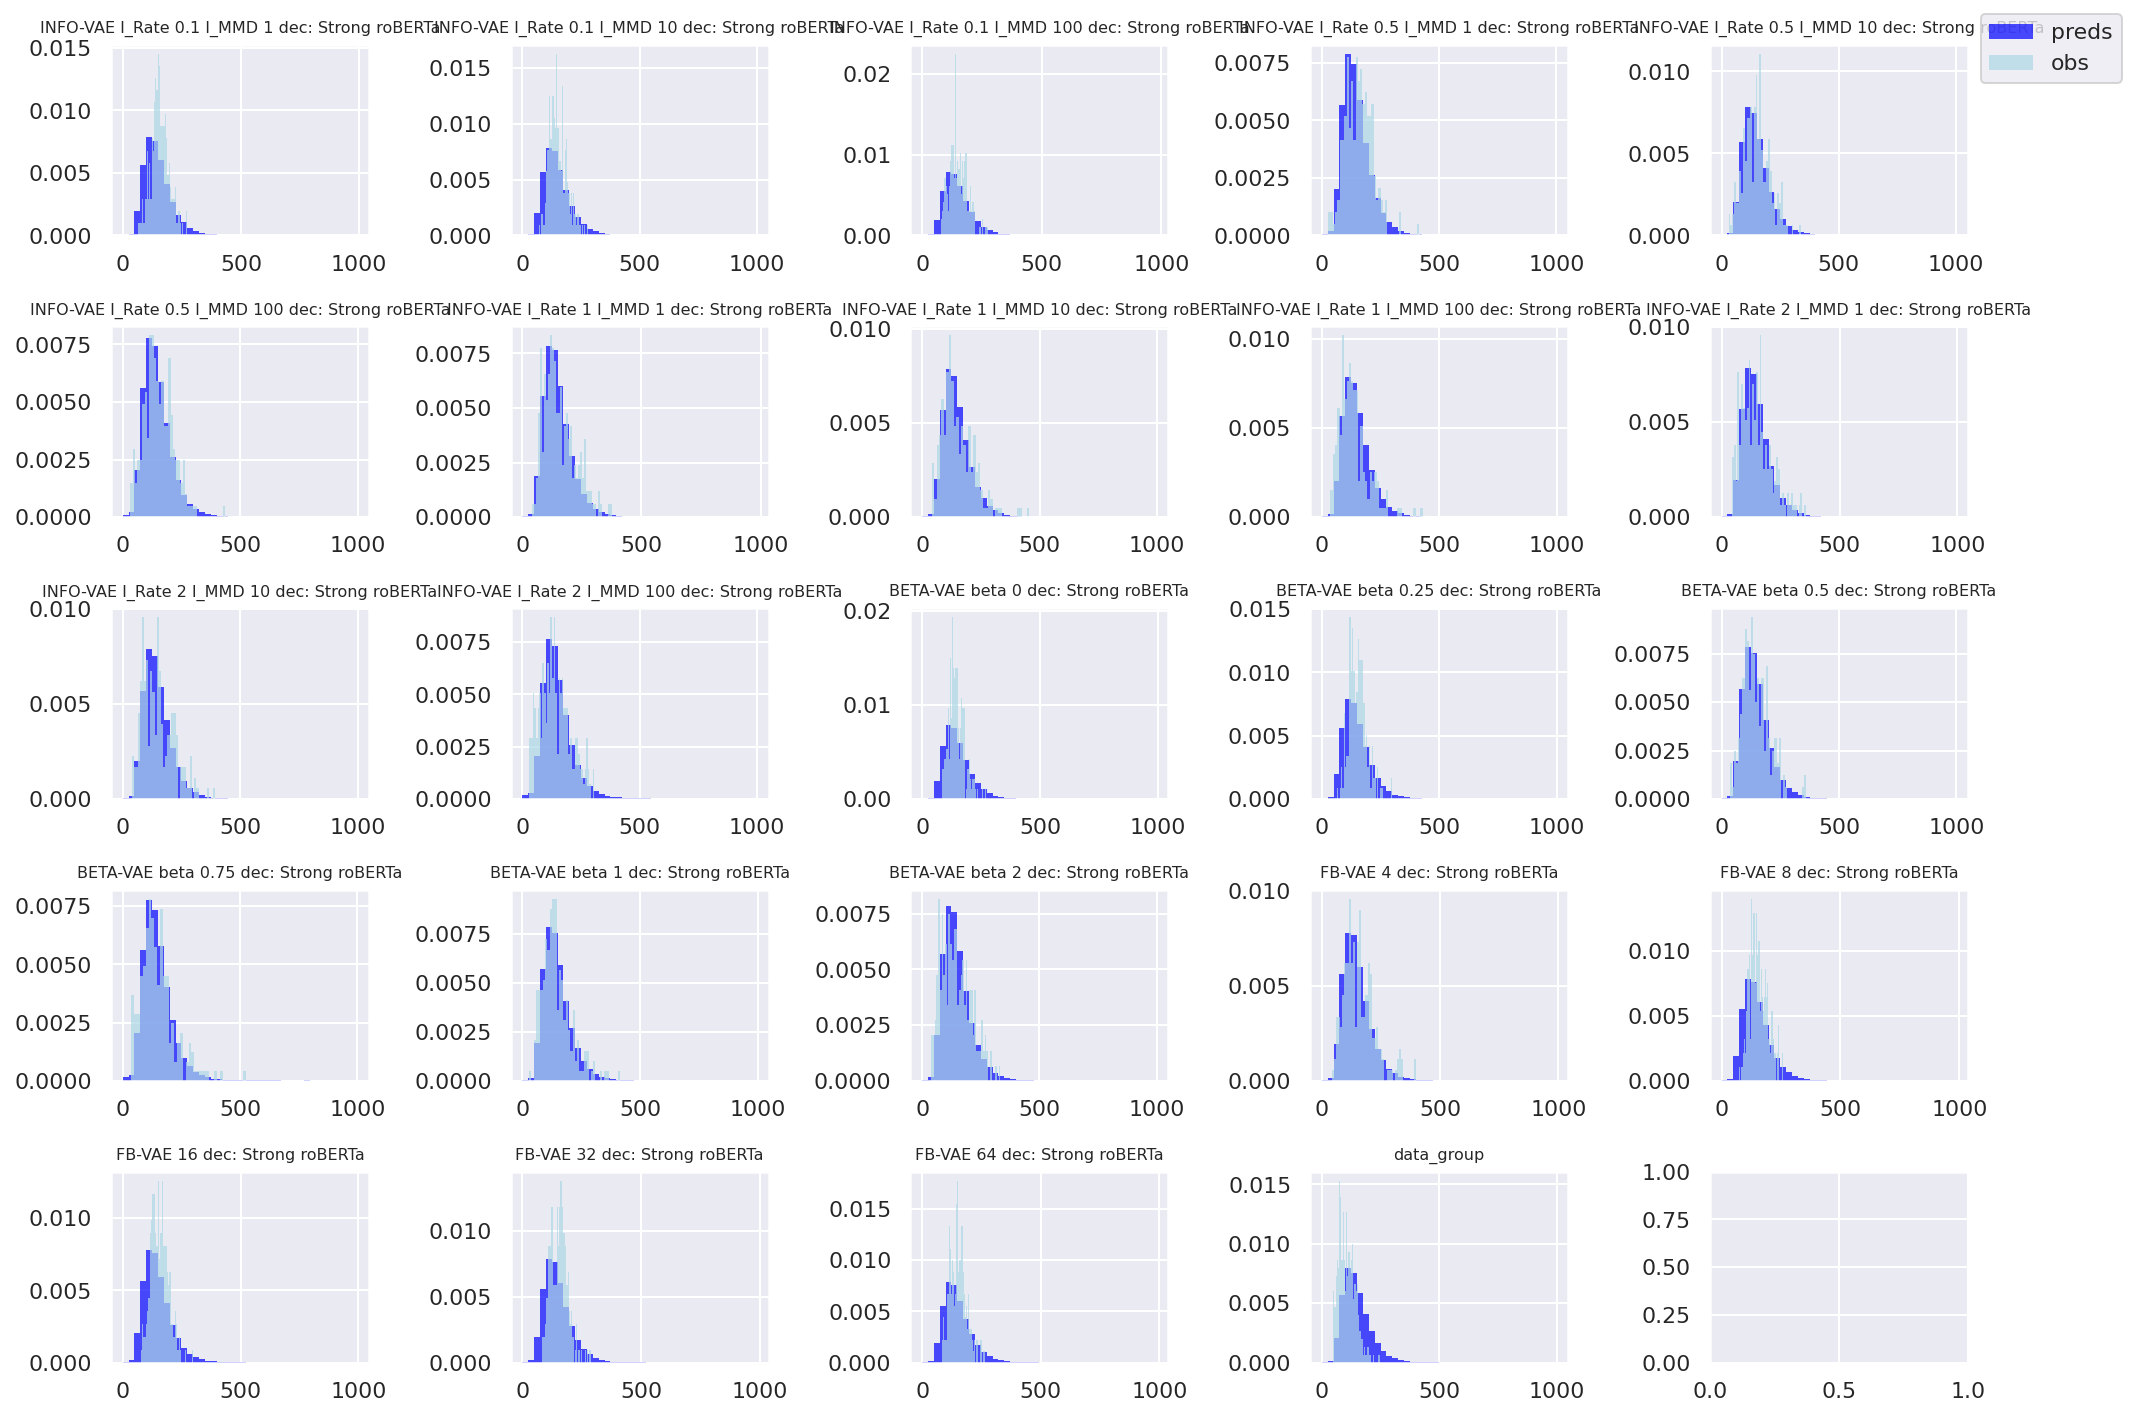

In [52]:
# print(stat_name)
# plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)

Leaving out autoencoder run with high R.
Rows: 22, cols: 3, every: 1, n_groups: 22


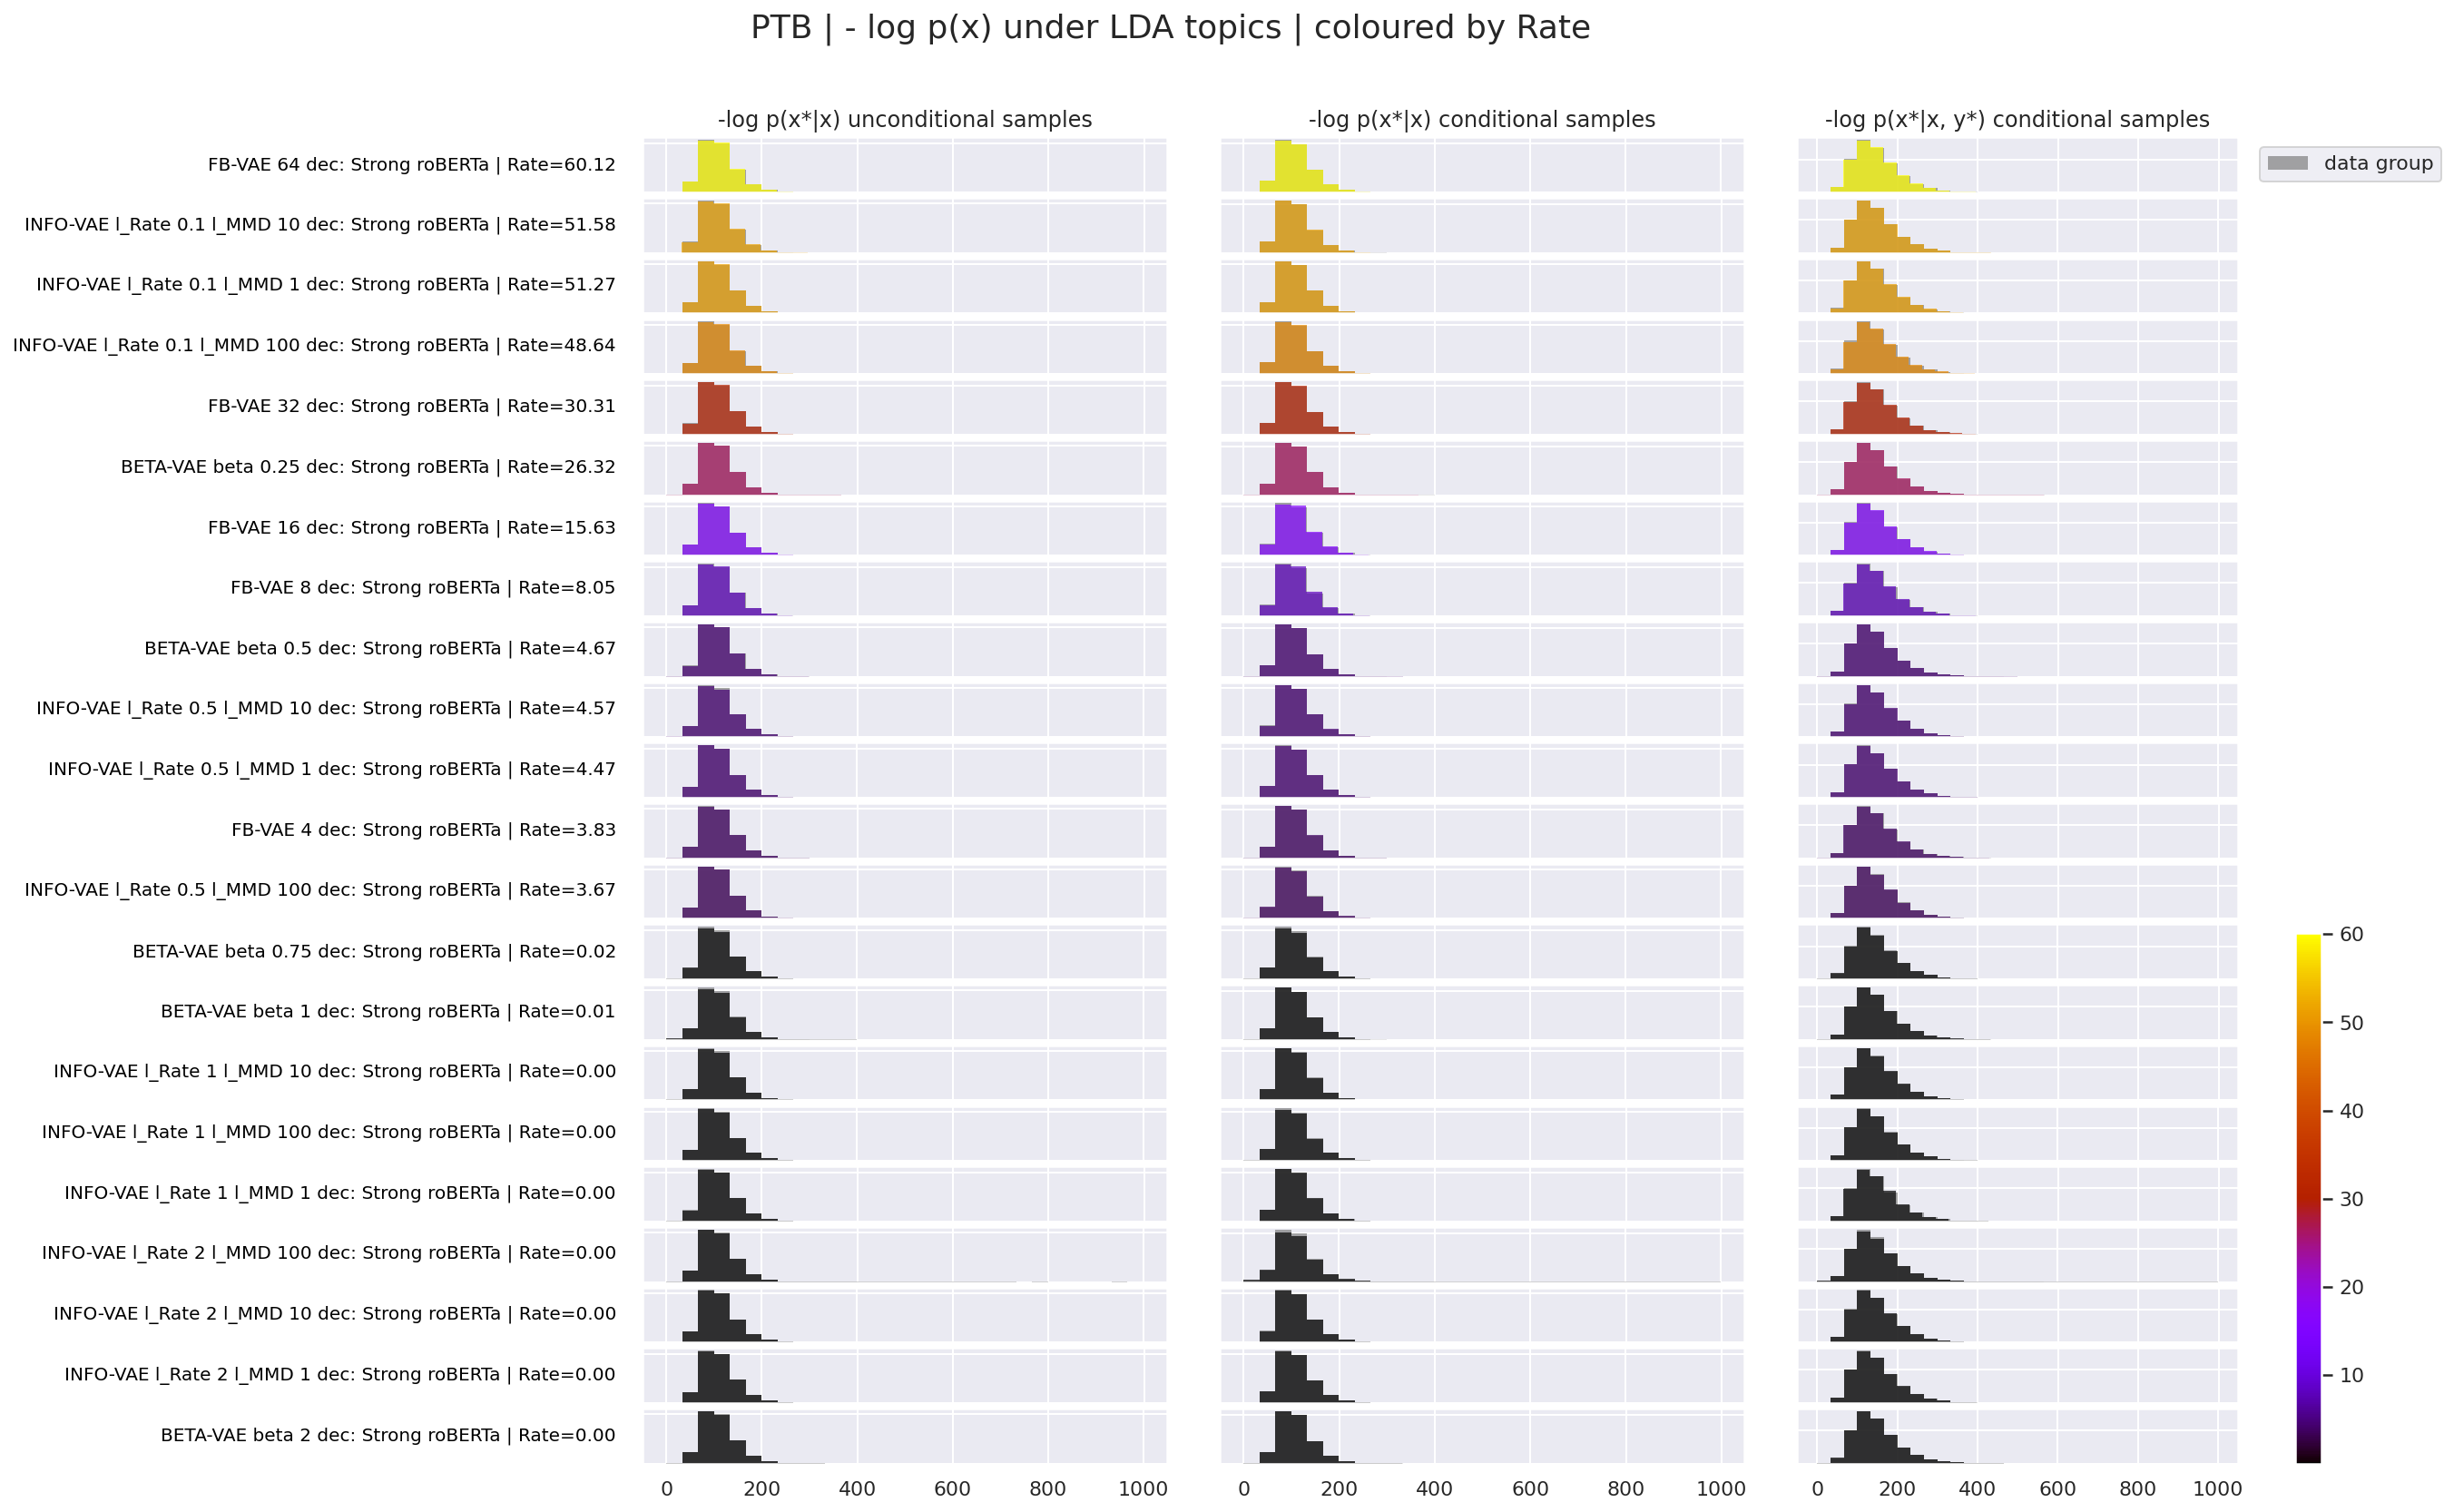

In [53]:
# xlims = [[0, 300], [0, 300], [0, 300]]
xlims = [None, None, None]

# xlims = [[0, 500], [0, 500], [0, 500]]
ylims = [None, None, None]

global_stats_df_filter = global_stats_df[global_stats_df["kl_prior_post"] < 70]
print("Leaving out autoencoder run with high R.")

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_pred_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="Rate", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.05,
                                         subsample_nrows=None, 
                                         sort_ascend=False, 
                                         row_height=0.5)

In [14]:


def kl_component_dist_and_data_group_distance(self):
    # [N_s, N_g, N_c]
    omega = self.posterior_samples["omega"]
    data_group_id = self.group_names.index("data_group")
    omega_data_group = omega[:, data_group_id, :]

    omega_tensor = torch.FloatTensor(np.array(omega))
    omega_data_group_tensor = torch.FloatTensor(np.array(omega_data_group)).unsqueeze(1)

    omega_dists = td.Categorical(probs=omega_tensor)
    omega_data_group_dists = td.Categorical(probs=omega_data_group_tensor)

    # [N_s, N_g, N_c] -> [N_s, N_g] -> [N_g]
    kl = td.kl_divergence(omega_data_group_dists, omega_dists)
    kl_all = kl.permute(1, 0) # [N_g, N_s]
    
    kl_avg = kl.mean(axis=0)  # avg sample dim: [N_s, N_g] -> [N_g]

    kl_comps_data_group_avg = dict()
    kl_comps_data_group_dists = dict()
    
    for group_idx, group_name in enumerate(self.group_names):
        
        kl_comps_data_group_avg[group_name] = kl_avg[group_idx].item()
        kl_comps_data_group_dists[group_name] = kl_all[group_idx, :].numpy()

    return kl_comps_data_group_avg, kl_comps_data_group_dists

def compute_all_divergences_data_model_groups(dp_mixtures, surprisal_values, num_components=3):
    from scipy import stats
    
    kl_component_assignments_all_dps = dict()
    
    kl_comp_dists = {}

    for stat, dp_mixture in dp_mixtures.items():
        # two dicts
        kl_comps_data_group_avg, kl_comps_data_group_dists = kl_component_dist_and_data_group_distance(dp_mixture)
        kl_component_assignments_all_dps["kl_comp " + stat] = kl_comps_data_group_avg
        kl_comp_dists[stat] = kl_comps_data_group_dists

    kl_component_assignments_all_dps_df = pd.DataFrame(kl_component_assignments_all_dps)
    kl_component_assignments_all_dps_df["kl_comp sum"] = kl_component_assignments_all_dps_df.sum(axis=1)

    kl_densities_all_dps = dict()
    for stat, dp_mixture in dp_mixtures.items():
        kl_density_est = estimate_kl_densities_dp_mixture(dp_mixture, num_components=num_components)
        kl_densities_all_dps["kl_dens " + stat] = kl_density_est

    kl_densities_all_dps_df = pd.DataFrame(kl_densities_all_dps)
    kl_densities_all_dps_df["kl_dens sum"] = kl_densities_all_dps_df.sum(axis=1)

    wass_dists = dict()

    for k, v in surprisal_values.items():
        if k is not "data_group":
            wass_dists[k] = dict()
            for stat_name, stat in v.items():
                w = stats.wasserstein_distance(stat, surprisal_values["data_group"][stat_name])
                wass_dists[k]["wasserstein " + stat_name] = w

    wasserstein_df = pd.DataFrame(wass_dists).transpose()
    wasserstein_df["wasserstein sum"] = wasserstein_df.sum(axis=1)

    all_df = wasserstein_df.join(kl_component_assignments_all_dps_df).join(kl_densities_all_dps_df)

    return all_df, kl_comp_dists

# Now assess "divergence" from model sample surprisal values from data group in three ways:

1. KL between component assignments under the DP Mixture
2. Difference between estimated densities under the DP Mixture
3. Wasserstein distance between surprisal value histograms (no DP Mixture used)

In [15]:
all_df, kl_comp_dists = compute_all_divergences_data_model_groups(dp_mixtures, 
                                                                  surprisal_values, 
                                                                  num_components=NUM_COMPS)


all_keys_present = True
for k in ["unconditional_unconditional", "unconditional_conditional", "conditional_conditional"]:
    if k not in kl_comp_dists:
        all_keys_present = False
print("all_keys_present", all_keys_present)

if all_keys_present:
    torch.save({"kl_comp_dists":kl_comp_dists, "divergence_df": all_df}, SAVE_DP_COMP_KL_DISTS_FILE)

I0121 08:07:13.227506 22967295749888 tpu_client.py:54] Starting the local TPU driver.
I0121 08:07:13.242232 22967295749888 xla_bridge.py:231] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
I0121 08:07:13.243580 22967295749888 xla_bridge.py:231] Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
I0121 08:07:13.244545 22967295749888 xla_bridge.py:231] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


kl shape torch.Size([1200, 24])
kl all shape torch.Size([24, 1200])
kl shape torch.Size([1200, 24])
kl all shape torch.Size([24, 1200])
kl shape torch.Size([1200, 24])
kl all shape torch.Size([24, 1200])
all_keys_present True


In [112]:
# N_groups = len(list(kl_comp_dists.values())[0])

# c_dict = {"unconditional_unconditional": "blue",
#           "conditional_conditional": "green",
#           "unconditional_conditional": "orange"}

# fig, axs = plt.subplots(ncols=3, nrows=N_groups, figsize=(14, 26), sharey="col")

# for col, (stat_name, kl_comps_dict) in enumerate(kl_comp_dists.items()):
#     for row, (name, kl_comp_vals) in enumerate(kl_comps_dict.items()):
        
#         if col == 1:
#             if row == 0:
#                 axs[row, col].set_title(name + "\n" + stat_name, size=8)
#             else:
#                 axs[row, col].set_title(name, size=8)
                
#         axs[row, col].hist(kl_comp_vals, bins=60, density=True, lw=0, color=c_dict[stat_name])
#         axs[row, col].axvline(np.mean(kl_comp_vals), color='r', linestyle='--')
#         axs[row, col].set_xlim([0.0, 0.2])
#         axs[row, col].set_yticklabels([])
        
# plt.tight_layout()

In [16]:
# SORT_ON = "kl_comp sum"
# plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only=None)

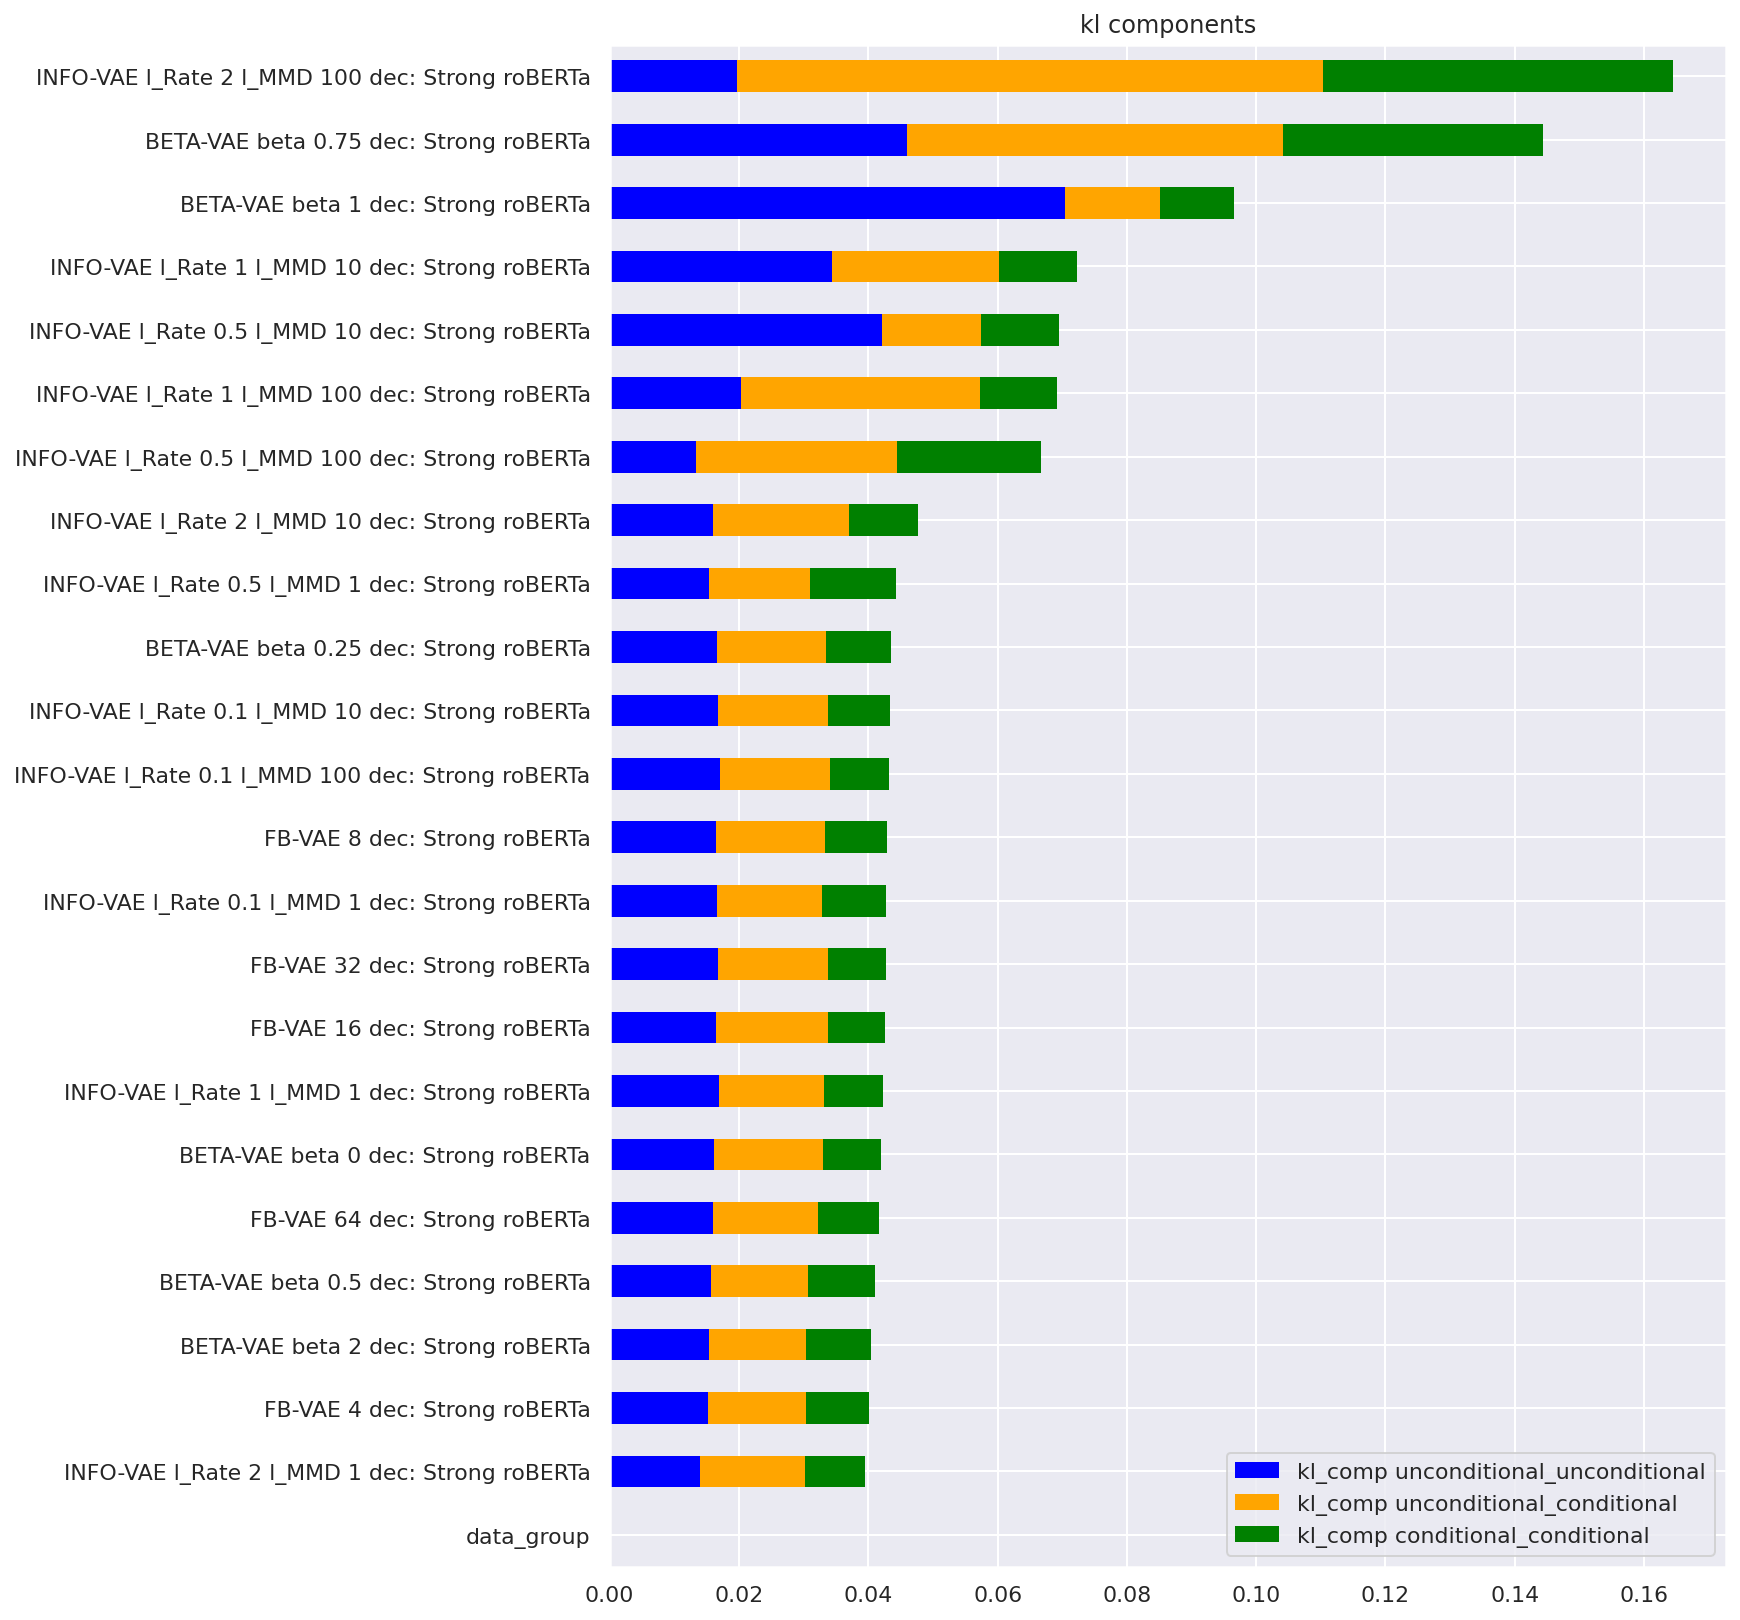

In [17]:
SORT_ON = "kl_comp sum"
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp", figsize=(10, 14))

In [ ]:
all_df

# Old code below

In [43]:
# from scipy.stats import truncnorm

# def plot_comps_normal(posterior_samples):
#     '''
#     beta     (400, 26, 3)
#     loc      (400, 4)
#     loc_z    (400, 5200)
#     omega    (400, 26, 4)
#     scale    (400, 4)
#     scale_z  (400, 5200)
#     y        (400, 5200)
#     z        (400, 5200)
#     '''
    
#     print(posterior_samples["scale_z"].shape)
#     print(posterior_samples["loc_z"].shape)
#     print(posterior_samples["z"].shape)
#     print(posterior_samples["z"][0, :10])
    
#     # [N, S]
    
    
    
# #     n_comps = posterior_samples["scale_z"].shape[1]
#     n_comps = 4
    
#     fig, axs = plt.subplots(nrows=2, ncols=n_comps, figsize=(3*n_comps, 6), sharex="row")
#     for comp in range(n_comps):
        
#         locs_comp = posterior_samples["loc_z"][posterior_samples["z"] == comp]
#         scales_comp = posterior_samples["scale_z"][posterior_samples["z"] == comp]
        
        
#         axs[0, comp].hist(np.array(locs_comp).flatten(), bins=30)
#         axs[0, comp].set_title(f"posterior dist Loc comp={comp}")
        
#         axs[1, comp].hist(np.array(scales_comp).flatten(), bins=30)
#         axs[1, comp].set_title(f"posterior dist Scale comp={comp}")
    
#     plt.tight_layout()
#     plt.show()

# plot_comps_normal(posterior_samples)

In [ ]:
# CODE_DIR = "/home/cbarkhof/fall-2021"
# ANALYSIS_DIR = f"{CODE_DIR}/analysis/analysis-files"
# SAMPLE_FILE = f"generative-samples.pt"
# CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

# MAX_MODEL_SAMPLES = 2000
# MODEL_SAMPLE_DIR = "/home/cbarkhof/fall-2021/clean_analysis/model_samples"

# ptb_model_text_samples = dict()

# for i, (clean_name, row) in enumerate(overview_df.iterrows()):
#     print(i, clean_name)
    
#     save_dir = f"{ANALYSIS_DIR}/{row.run_name}"
#     conditional_sample_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
#     sample_file = f"{save_dir}/{SAMPLE_FILE}"
    
#     res = dict()
    
#     if os.path.exists(conditional_sample_file):
#         cond_samples = torch.load(conditional_sample_file)
#         res["conditional_original_text"] = cond_samples["valid"]["original_input_text"][:MAX_MODEL_SAMPLES]
#         res["conditional_sampled_text"] = cond_samples["valid"]["condtional_sample_text"][:MAX_MODEL_SAMPLES]
    
#     if os.path.exists(sample_file):
#         samples = torch.load(sample_file)
#         res["unconditional_sampled_text"] = samples["text"][:MAX_MODEL_SAMPLES] 
    
#     os.makedirs(MODEL_SAMPLE_DIR + "/" + row.run_name, exist_ok=True)
#     torch.save(res, MODEL_SAMPLE_DIR + "/" + row.run_name + "/" + "conditional_unconditional_samples.pt")